In [1]:
import xml.etree.ElementTree as ET
import os
import sys
sys.path.append("conceptual_spaces")
import cs.cs as space
from cs.weights import Weights
from cs.cuboid import Cuboid
from cs.core import Core
from cs.core import from_cuboids
from cs.concept import Concept
import matplotlib.pyplot as plt
import visualization.concept_inspector as ci
import numpy as np
from matplotlib import patches
from sklearn.metrics import average_precision_score
from functools import reduce
from math import isnan
import random
import _pickle as pkl

C=0.05
#Get data from path to xml and add to given data
def xml_to_dict(path, data = {}, domain_mapping={}, dimension_names=[]):
    with open(os.path.normpath(path), 'rb') as xml_file:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        newdata={}
        for exemplar in root:
            new_concept = get_domains(exemplar)
            if(new_concept):
                newdata[exemplar.attrib['name']] = new_concept

    n_old=len(dimension_names)
    domains={}
    for exemplar in newdata.values():
        domains.update(exemplar)
    del(domains['supercategory'])

    #domains = mapping: domain->dimension indices, also add new dimension names
    if domain_mapping:
        i=sum([len(domain) for domain in domain_mapping.values()])
    else:
        i=0
    for key in domains:
        if not key in domain_mapping:
            for dim in domains[key]:
                dimension_names+=[dim]
            domain_mapping[key]=list(range(i,i+len(domains[key])))
            i+=len(domains[key])

    #kick inconsistents
    to_del=[]
    for datum in newdata:
        if not is_consistent(newdata[datum], domain_mapping):
            print(datum ,'is inconsistent')
            to_del+=[datum]
    for kickit in to_del:
        del(newdata[kickit])

    #translate to point
    for datum in newdata:
        point=[]
        for domain in domain_mapping:
            if domain in newdata[datum]:
                point+=list(newdata[datum][domain].values())
            else:
                point+=[float('inf')]*len(domain_mapping[domain])     
        newdata[datum]={'supercategory':newdata[datum]['supercategory'], 'point':point}
    if len(dimension_names)>n_old and n_old:
        for datum in data:
            data[datum]['point']=data[datum]['point']+[float('inf') for _ in range(len(dimension_names)-n_old)]
    data.update(newdata)
    return domain_mapping, data, dimension_names

def less_dimensions(domain_mapping, data, dim_names,threshold=10):
    dimcounter={}
    for domain in domain_mapping:
        dimcounter[domain]=sum([1 if not datum['point'][domain_mapping[domain][0]] == float('inf') else 0 for datum in data.values()])


    for domain in dimcounter:
        if dimcounter[domain]<threshold:
            del(domain_mapping[domain])
    indices=[value for domain in domain_mapping.values() for value in domain]
    for concept in data.values():
        concept['point']=[value for value,i in zip(concept['point'],range(len(concept['point']))) if i in indices]

    dim_names=[value for value,i in zip(dim_names,range(len(dim_names))) if i in indices]
    i=0
    for domain in domain_mapping:
        if domain_mapping[domain][0]==i:
            i+=len(domain_mapping[domain])
        else:
            domain_mapping[domain]=[i+j for j in range(len(domain_mapping[domain]))]
            i+=len(domain_mapping[domain])
    return domain_mapping, data, dim_names
    
def family_into_space(name, values, add=True):
    cuboids=[]
    domains = {}
    for point in values:
        subdomains=point_to_domains(point)
        cuboids.append(Cuboid([dim if not dim==float('inf') else -dim for dim in point], point, subdomains))
        domains.update(subdomains)

    core=from_cuboids(cuboids,domains)
    weights=Weights(space._def_dom_weights,space._def_dim_weights)
    concept=Concept(core, 1.0, C, weights)
    if add:
        space.add_concept(name,concept)
    return concept
         
#Group data by their supercategories to form concepts
def form_supercategories(data):
    concepts={}
    for datum in data.values():
        if datum['supercategory'] in concepts:
            concepts[datum['supercategory']].append(datum['point'])
        else:
            concepts[datum['supercategory']]=[datum['point']]
        #del(concepts[datum['supercategory']])
    return concepts
    
#helper for xml_to_dict, important for how the data is supposed to look like
def get_domains(xml_elem):
    domains = xml_elem.find('genericPhysicalDescription')
    if(not(domains)):
        return
    domain_dict={}
    try:
        supercategory = xml_elem.find('family').text
        if supercategory in ['feline','rodent','primate','cetacean']:
            supercategory='mammal'
        elif supercategory in ['crustacean','arachnid']:
            supercategory = 'arthropod'
        elif supercategory in ['fruit', 'transport', 'furniture', 'book', 'building', 'musical_instrument', 'present', 'architectural_element', 'amphibian']:
            supercategory = 'object'
            return
        domain_dict['supercategory']=supercategory
    except AttributeError:
        domain_dict['supercategory']="object"
        return
        
    for domain in domains:
        domain_name=domain.tag
        if domain_name=='hasPart':
            domain_name=domain.get('name')
            if domain[0].tag=='number':
                domain_dict['n_'+domain_name]={'number_'+domain_name:float(domain[0].text)}
            else:
                pass
        else:
            numerical_domain={}
            for subelem in domain:
                try:
                    numerical_domain[subelem.tag]=float(subelem.text)
                except ValueError:
                    pass
            if numerical_domain:            
                if domain_name=='size' or domain_name=='location' or domain_name=='color' or domain_name=='locomotion':
                    domain_dict[domain_name]={key:value for key,value in zip(numerical_domain.keys(),numerical_domain.values())}
    return domain_dict

def domains_from_point(point):
    domains={}
    for domain in space._domains:
        if all(not point[dim]==float('inf') for dim in space._domains[domain]):
            domains[domain]=space._domains[domain]
    return domains

def point_to_concept2(point, name, size=100000, weights=[]):
    domains = domains_from_point(point)
    p_min=[-size for value in point]
    p_max=[size for value in point]
    c_example = Cuboid(p_min, p_max, domains)
    s_example = Core([c_example], domains)
    if not weights:
        weights=space._def_dom_weights
    w_example = Weights(weights,space._def_dim_weights)
    concept = Concept(s_example, 1.0, C, w_example)
    space.add_concept(name, concept)
    return concept

def point_to_concept(point, name, weights=[]):
    domains = domains_from_point(point)
    p_min=[value if not value==float('inf') else float('-inf') for value in point]
    c_example = Cuboid(p_min, point, domains)
    s_example = Core([c_example], domains)
    if not weights:
        weights=space._def_dom_weights
    w_example = Weights(weights,space._def_dim_weights)
    concept = Concept(s_example, 1.0, C, w_example)
    space.add_concept(name, concept)
    return concept

#gives all permutations of a binary vector of given length with -1 and 1 as elements
def get_permutations(length):
    if length==1:
        #positive first, because later on earlier permutations are preferred
        return [[[1]],[[-1]]]
    else:
        new_vectors=[]
        for vector in get_permutations(length-1):
            new_vectors+=[vector+[[1]],vector+[[-1]]]
        return new_vectors
    
def evaluate_signs(signs):
    #max(evaluate_signs) -> maximize cumulative similarity of columns
    value=0
    for dimension in signs.T:
        value+=abs(sum(dimension))
    return value

#'brushes' all vectors to point in the most common general direction
def brush_vectors(pc1s):
    signs=np.zeros(pc1s.shape)
    for j in range(len(signs)):
        for i in range(len(signs[j])):
            if pc1s[j,i]>0:
                signs[j,i]=1
            elif pc1s[j,i]<0:
                signs[j,i]=-1
    permutations=get_permutations(len(signs))
    signs_x_perms=np.array([perm*signs for perm in permutations])
    return pc1s*permutations[np.argmax([evaluate_signs(brushed_pc1s) for brushed_pc1s in signs_x_perms])]

def brush_to_size(pc1s):
    indices=[space._dim_names.index('x'),space._dim_names.index('y'),space._dim_names.index('z')]
    newpc1s=[]
    for pc1 in pc1s:
        if sum(pc1[indices])>0:
            newpc1s.append(pc1)
        else:
            newpc1s.append(-pc1)
    return np.array(newpc1s)


#We do not want any concepts with partially filled domains. This would go against the very idea of domains. input: {doms:values}. Also concepts with only undefined dims are not needed
def is_consistent(concept, domain_mapping={}):
    inf_check=[]
    '''if not domain_mapping:
        domain_mapping=space._domains'''
    for domain in concept:
        if not domain=='supercategory':
            if not(len(concept[domain])==len(domain_mapping[domain])):
                return False
            inf_check+=concept[domain]
    if all([check==float('inf') for check in inf_check]):
        return False
    return True

#normalize by data with missing values replaced my mean
def normalize_to_standard_score(points):
    #calculate means af defined values for each dimension
    means=[]
    for dimension in zip(*points):
        values=[x for x in dimension if not (x==float('inf') or np.isnan(x))]
        if len(values):
            means.append(sum(values)/len(values))
        else:
            means.append(0)
    means=np.array(means)
    
    #copy data, replace missing values by mean
    normalized_data=np.zeros(np.shape(points))
    for j in range(len(points)):
        for i in range(len(points[j])):
            normalized_data[j][i]=points[j][i] if not (points[j][i]==float('inf') or np.isnan(points[j][i])) else means[i]
            
    #calculate the std in each dimension
    stds=np.std(normalized_data, axis = 0)
    #stds of 0 zero are considered to be inf, in order to avoid division by zero
    stds=np.array([std if not std==0 else float('inf') for std in stds])
    #normalize data to standard score
    normalized_data = [(point-means)/stds for point in normalized_data]
    #for the inverse function a std of zero is ok again, inverse fun not implemented, only "amount" of one std
    stds=np.array([std if not std==float('inf') else 0 for std in stds])
    #inverse_fun = lambda x:x*stds+means
    return stds, np.array(normalized_data)

'''def get_names(domains):
    dimension_names = []
    for domain in domains.values():
        dimension_names += [dim for dim in domain.keys()]'''
        
'''def dict_to_point(concept_dict):
    point=[concept_dict.get(domain,{str(key):float("inf") for key in range(len(space._domains[domain]))}).values() for domain in space._domains]
    #flatten
    point= [p for dom in point for p in dom]
    return point'''

def point_to_domains(point):
    domains={}
    for dim in range(space._n_dim):
        if not(point[dim]==float('inf') or point[dim]==float('-inf')):
            domains[space.dim_to_dom[str(dim)]]=space._domains[space.dim_to_dom[str(dim)]]
    return domains

def one_shot(point, method=None, sibblings=None, name="newlearned", learn_weights=False):
    #right now unnecessary because by now only two_cubs_PCA is left over (actually naive_with_size, too), but cool python stuff
    return method(point, sibblings, learn_weights=learn_weights)

def two_cubs_PCA(point, sibblings, learn_weights=False):
    #sibbling is list of sibbling names or dict with sibbling names as keys
    #We can play around with artificial_scaling to see the effect of arbitrary generalization (<1 does not really mean more specific, but rather just smaller/conservative)
    artificial_scaling=1
    n_dims=len(point)
    if sibblings==None:
        #not implemented for some reason
        sibblings=get_sibblings(supercategory)   
    variances=[]
    pc1s=[]
    #correlations=[]
    examples_x_stds=[]#Matrix examples x stds
    avg = np.average#lambda values: sum(values)/len(values)
    allcenters=[]
    for sibbling in sibblings:
        #centers of all cuboids of the sibbling concept
        centers = np.array([[(p_max+p_min)/2 for p_max,p_min in zip(cuboid._p_max, cuboid._p_min)] for cuboid in space._concepts[sibbling]._core._cuboids])
        #throw away concepts with less than 2 cuboids (not happening with dataset)
        if len(centers)>1:
            allcenters.append(centers)
            #Centers are translated to data cloud that has std=1 in every dimension. stds remembers the multiplicative(eng?) part of the reverse operation
            #as simpler version compared to regression
            stds, data=normalize_to_standard_score(centers)
            examples_x_stds.append(stds)
            #np.cov input: rows=dimensions, columns=observations!! (very likely to produce error down the line if done wrong though)
            #np.linalg.eig output: values=eigenvalues, vectors=eigenvectors in columns!! (no error when done wrong because square matrix!)
            values, vectors = np.linalg.eig(np.cov(data.T))
            #the first PC has unit length so multiplying it with std lets it have (euclidean) length=std (in direction of largest var)
            pc1s.append(np.array(vectors[:,np.argmax(values)])*(max(values)**(1/2)))
        
    #The sign of a whole PC is only meaningfull in relation to the other PCs, so we assume that all first PCs point in a somewhat similar direction. Size is ignored.
    pc1s=brush_vectors(np.array(pc1s))
    #makes signs point in a direction so that the size dimension still correlate with each other over all examples
    pc1s=brush_to_size(pc1s)
    
    #A dimension of a PC that is zero because the original values where all undefined is considered uninformative, since examples
    #that have an undefined value lead to a concept with no variance in that dimension anyways
    meanpc=[]
    for dimension, dimindex in zip(pc1s.T, range(len(pc1s.T))):
        #all meaningfull values of the 1st PCs of all known concepts in a single dimension
        cleanvalues=[]
        for value, conceptindex in zip(dimension, range(len(dimension))):
            #print([np.isnan(examplevalue[dimindex]) for examplevalue in allcenters[conceptindex]])
            #print(conceptindex)
            if not value==0:
                cleanvalues.append(value)
            #a variance of 0 in a certain dimension in the first PC can be due to all known examples of a category being undefined in that dimension
            #the other way round this implies that some values have not been included because of the wrong reasons beforehand
            elif not all([np.isnan(examplesvalues[dimindex]) for examplesvalues in allcenters[conceptindex]]):
                cleanvalues.append(value)

        if len(cleanvalues):
            #quite some information is lost in this step (PCs canceling out each other because of wrong reasons), but we need to generalize
            meanpc.append(sum(cleanvalues)/len(cleanvalues))
        else:
            #Should not happen, since uninformative dimensions have already been kicked out. If it happens anyways, zero  is actually the correct value
            #(i.e. no variance in dim with only undefined values)
            meanpc.append(0)

    meanstds=np.average(examples_x_stds, axis=0)

    
    #for some reason i=0 happens quite often, although the docu promises that real values are used in these cases
    meanpc=[np.real(val) for val in meanpc]
    
    #We have our background knowledge. Nice! Multiplying with the mean 'size' in each dimension is improvable (multiplicative part of regression would be better)
    learnt_vector=meanstds*meanpc
    
    #start building our new concept
    cub1=np.zeros(n_dims)
    cub2=np.zeros(n_dims)
    
    for dim in range(n_dims):
        #point as central region, multiply by two to reverse taking center of cuboids
        cub1[dim]=point[dim]-learnt_vector[dim]*2*artificial_scaling
        cub2[dim]=point[dim]+learnt_vector[dim]*2*artificial_scaling

    c1_p_min=[cub1[dim] if cub1[dim] < point[dim] else float('-inf') if point[dim]==float('inf') else point[dim] for dim in range(n_dims)]
    c1_p_max=[cub1[dim] if cub1[dim] > point[dim] else point[dim] for dim in range(n_dims)]
    
    c2_p_min=[cub2[dim] if cub2[dim] < point[dim] else float('-inf') if point[dim]==float('inf') else point[dim] for dim in range(n_dims)]
    c2_p_max=[cub2[dim] if cub2[dim] > point[dim] else point[dim] for dim in range(n_dims)]
    
    domains = domains_from_point(c1_p_max)
    core=Core([Cuboid(c1_p_min, c1_p_max, domains),Cuboid(c2_p_min,c2_p_max,domains)],domains)
    
    if not learn_weights:
        dom_weights=space._def_dom_weights
    else:
        #dramatically improves performance, but seems unfair to compare to classes with meaningless weights
        dom_weights={}
        for domain in domain_mapping:
            variance=np.average([abs(meanpc[dim]) for dim in domain_mapping[domain]])+0.1            
            dom_weights[domain]=(1/variance)**100
        
    weights=Weights(dom_weights,space._def_dim_weights)
        
    concept=Concept(core, 1.0, C, weights)

    return concept
    
def naive_with_size(point, sibblings):
    #actually not bad for comparison, lets keep it for now
    learnt=two_cubs_pca(point,sibblings)
    size=learnt.size()
    print('size:',size)
    avg_dim_size=np.average([[np.average(cuboid._p_max[dimension]-cuboid._p_min[dimension]) for cuboid in learnt._core._cuboids] for dimension in range(len(learnt._core._cuboids[0]._p_min))])
    print(avg_dim_size)
    crisp_size=learnt.size_given_c(1000000000)
    print('crisp_size:',crisp_size)
    return avg_dim_size

def ap_balanced(concept, testdata={}, figure=None, target=None):
    class_size=len(testdata[target])-(len(testdata[target])%(len(testdata)-1))
    balanced_data={target:testdata[target][20:class_size+21]}
    for family in testdata:
        if not family==target:
            balanced_data[family]=testdata[family][:int(class_size/(len(testdata)-1))]
    return average_precision(concept,testdata=balanced_data, target=target)
    
def average_precision(concept, testdata={}, figure=None, target=None):#old signature!
    """Average Precision of the concept as a classifier

    Parameters:
    negatives (list): list of points that do not belong to the target class
    positives (list):...

    Returns:
    ap (float)

   """
    negatives=[point for family in testdata for point in testdata[family] if not family==target]
    positives=[point for family in testdata for point in testdata[family] if family==target]
    #negatives=reduce(lambda x,y:x+y, list(negatives.values()))
    y_true=np.concatenate((np.ones(len(positives)),np.zeros(len(negatives))))
    y_scores=np.zeros(len(y_true))
    for i in range(len(y_scores)):
        if i < len(positives):
            y_scores[i]=concept.membership_of(positives[i])
        else:
            y_scores[i]=concept.membership_of(negatives[i-len(positives)])
    sorted_truths=[[y,x] for y,x in sorted(zip(y_scores,y_true),reverse=True)]
    recalls=[]
    precisions=[]
    i=0
    while i < len(sorted_truths):
        j=0
        if i+1<len(sorted_truths):
            while sorted_truths[i][0]==sorted_truths[i+j+1][0]:
                if i+j+2<len(sorted_truths):
                    j+=1
                else:
                    break
        tp=sum([truth[1] for truth in sorted_truths[:i+1+j]])
        t=len(positives)
        p=i+j+1
        recalls.append(tp/t)
        precisions.append(tp/p)
        for _ in range(j):
            i+=1
        i+=1

    #plt.subplots(figsize=(10, 10))
    if figure=='part':
        plt.scatter(recalls, precisions, color = color)#[(0.5,x,x) for x in [(len(recalls)-i)/len(recalls) for i in range(len(recalls))]])
    elif figure=='developement':
        plt.scatter(recalls, precisions, color = [(0.5,x,x) for x in [(len(recalls)-i)/len(recalls) for i in range(len(recalls))]])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
    #plt.figure(figsize=(10,20))
    #plt.show()
    ap=average_precision_score(y_true, y_scores)
    '''print(y_true)
    print(y_scores)
    print(ap)'''
    return ap

#normalizes values to sum(values)=1
def normalize(values):
    if not sum(values):
        return([1/len(values) for _ in values])
    summed=sum(values)
    for i in range(len(values)):
        values[i]=values[i]/summed

#cheap workaround, but lets be honest, that way we are on the save side, especially in jupyter
class Memorizer:
    memberships={}
    def memorize_memberships(learnt_classes, testdata):
        flattened_data=[datum for family in learnt_classes for datum in testdata[family]]
        for concept in learnt_classes:
            Memorizer.memberships[concept]=[learnt_classes[concept].membership_of(datum) for datum in flattened_data]
        print(Memorizer.memberships)
    
    def deserialize_memberships():
        with open('memberships', 'rb') as file:
            Memorizer.memberships=pkl.load(file)
    n_log0=0
    
def log(x):
    #in information theory log means log_2 since naturalis already has ln(x) as notation
    return np.log2(x)
     
def categorical_cross_entropy(concept, testdata, target, figure=None):
    '''compute the categorical cross entropy from a classifier consisting of our existing concepts, where one can be replaced
    with the concept parameter (concept for target), to a theoretical perfect classifier'''
    #Since officially there is no ordering in dictonaries, this:
    indices={family:index for family,index in zip(testdata,range(len(testdata)))}
    
    predictions=[]
    for family in indices:
        i=0
        for testdatum in testdata[family]:
            i+=1
            #absolute certainty of each class for the example
            all_predictions=[space._concepts[conc].membership_of(testdatum) if not conc==target else concept.membership_of(testdatum) for conc in indices]
            #relative certainty of each class for the example, with assumed equipropable a priori propabilities
            normalize(all_predictions)
            #only the prediction for the class from which the example was drawn is relevant, all others would be multiplied by zero down the line
            pred_target=all_predictions[indices[family]]
            predictions.append(pred_target)

    cross_entropies=[]
    #iterate through examples
    for pred in predictions:
        #might be inf
        cross_entropies.append(-log(pred))

    #annoying but really informative, regarding individual examples
    print('score:',np.median(cross_entropies))
    
    #median because mean is too susceptible for inf values
    return np.median(cross_entropies)

def sample_data(n, a=2):
    '''Crisp sampling with n examples drawn per class, n%10=0
    Returns: testdata (dict): {class: point (list)}
    '''
    domain_mapping, data, dim_names = xml_to_dict("Dataset\\prototypes.xml")
    domain_mapping, data, dim_names = xml_to_dict("Dataset\\exemplars.xml", domain_mapping=domain_mapping, data=data, dimension_names=dim_names)
    domain_mapping, data, dim_names = less_dimensions(domain_mapping, data, dim_names)
    space.init(len(dim_names), domain_mapping, dim_names)

    concepts=form_supercategories(data)

    random.seed(a=a)

    testdata={}
    families={}
    i=1
    for concept in concepts:
        print(concept)
        families[concept]=family_into_space(concept, concepts[concept],add=False)
        conc=families[concept]
        testdata[concept]=[]
        for j in range(int(n/10)):
            testdata[concept]+=conc.crisp_sample(10)
            print(i,j*10)
        i+=1
        
    #no examples without information
    for family in testdata:
        for i in range(n):
            while all([value==float('inf') for value in testdata[family][i]]):
                testdata[family][i]=families[family].crisp_sample(1)[0]
    
    return testdata
    
def serialize_testdata(testdata, path='testdata.pkl'):
    with open(path, 'wb') as file:
        pkl.dump(testdata,file)
        
def deserialize_testdata(path):
    with open(path, 'rb') as file:
        data=pkl.load(file)
    return data
    
def evaluate_example(example, data, concepts, domains, dim_names, figure=None, method=two_cubs_PCA, testdata={}, criterion=average_precision, learn_weights=False):
    """Look what would happen, if example was a OSL input

    Parameters:
    example (dict): {'target': name of target class (str), 'point': values of the datum (list), 'n': count of examples from target, used for naming (int)}
    or
    example (str): name of traindatum (e.g. 'Rhinozeros')

    concepts (dict): returned from form_supercategories, {class: traindata for class} 

    Returns:
    aps (dict): complete evaluation, ordered by inputs

    """
    space.init(len(dim_names), domains,dim_names)
    
    #translate traindata into concepts, and put them into space
    classes={name:family_into_space(name, values) for name,values in zip(concepts,concepts.values())}
    
    #criterion removed
    '''if criterion==complete_categorical_cross_entropy:
        Memorizer.deserialize_memberships()'''

    if isinstance(example,dict):
        target=example['target']
        examplename='some'+target+str(example['n'])
        example=example['point']
    else:
        #example taken from trainset (ok because of leave-one-out evaluation, but unbalanced)
        target=data[example]['supercategory']
        examplename=example
        example=data[example]['point']
        testdata=list(concepts[target])
        testdata.remove(data[examplename]['point'])

    '''testset=list(concepts[target])
    if not traindata:
        try:
            testset.remove(data[examplename]['point'])
        except:
            pass
    
    if not testdata:
        negatives={family:[point for point in trainset[family]] for family in trainset}
        positives=testset
    else:
        negatives=testdata.copy()
        del(negatives[target])
        positives=testdata[target]'''
    
    sibblings = [concept for concept in space._concepts if not concept==target]
    learnt_category=one_shot(example, method,sibblings=sibblings,name=target+'from'+examplename,learn_weights=learn_weights)
    
    #start cheating
    centers = np.array(concepts[target]).T
    means=[]
    for dimension in range(len(centers)):
        means.append(np.average([value for value in centers[dimension] if not value==float('inf')]))
    means=[mean if not np.isnan(mean) else float('inf') for mean in means]
    cheated=one_shot(means, method,sibblings=sibblings,name=target+'cheatedfrom'+examplename,learn_weights=learn_weights)
    target_dict={}
    known=space._concepts[target]
        
    if not learn_weights:
        weights=space._def_dom_weights
    else:
        weights=learnt_category._weights
        known._weights=weights

    #A size of 100000 entails all data we have in our data
    naive_big=point_to_concept2([0 for _ in example],'naive_big', 100000,weights)
    
    print('\n\nExample:',examplename)
    print('\nlearnt')
    eval_learnt=criterion(learnt_category, testdata=testdata, figure=figure, target=target)
    print('\nnaiveBig')
    ap_naive=criterion(naive_big, testdata=testdata, figure=figure, target=target)
    
    print('\nnaiveSmall')
    naive_small=point_to_concept(example,'naive',weights=weights)
    ap_naive2=criterion(naive_small, testdata=testdata,figure=figure, target=target)

    
    print('\nknown')
    ap_known=criterion(known, testdata=testdata, figure=figure, target=target)
    
    print('\ncheated:')
    ap_cheated=criterion(cheated, testdata=testdata, figure=figure, target=target)
    
    print('\ncheated2')
    ap_cheated2=criterion(cheated2, testdata=testdata, figure=figure, target=target)
    
    return {examplename:[eval_learnt, ap_naive, ap_naive2, ap_known, ap_cheated]}

def print_evaluation(aps):
    diff_ap=[x[0] for x in aps.values()]
    print('learnt')
    print('max',max(diff_ap),'(',list(aps.keys())[np.argmax(diff_ap)],')')
    print('min',min(diff_ap),'(',list(aps.keys())[np.argmin(diff_ap)],')')
    print('avg',sum(diff_ap)/len(diff_ap))

    diff_ap=[x[1] for x in aps.values()]
    print('naive big')
    print('max',max(diff_ap))
    print('min',min(diff_ap))
    print('avg',sum(diff_ap)/len(diff_ap))

    diff_ap=[x[2] for x in aps.values()]
    print('naive small')
    print('max',max(diff_ap),'(',list(aps.keys())[np.argmax(diff_ap)],')')
    print('min',min(diff_ap),'(',list(aps.keys())[np.argmin(diff_ap)],')')
    print('avg',sum(diff_ap)/len(diff_ap))

    diff_ap=[x[3] for x in aps.values()]
    print('known')
    print('max',max(diff_ap))
    print('min',min(diff_ap))
    print('avg',sum(diff_ap)/len(diff_ap))

    diff_ap=[x[4] for x in aps.values()]
    print('cheated')
    print('max',max(diff_ap))
    print('min',min(diff_ap))
    print('avg',sum(diff_ap)/len(diff_ap))
    
def evaluate_on_dataset(testdata, criterion):
    #read concepts from prototypes and exemplars
    domain_mapping, data, dim_names = xml_to_dict("Dataset\\prototypes.xml")
    domain_mapping, data, dim_names = xml_to_dict("Dataset\\exemplars.xml", domain_mapping=domain_mapping, data=data, dimension_names=dim_names)
    domain_mapping, data, dim_names = less_dimensions(domain_mapping, data, dim_names,threshold=10)
    space.init(len(dim_names), domain_mapping, dim_names)

    concepts=form_supercategories(data)

    aps={}
    for target in testdata:
        n=0
        if len(concepts[target])-1:
            for example in testdata[target]:

                n+=1
                ex={'target':target,'point':example,'n':n}
                #print(ex['target'],ex['n'])
                aps.update(evaluate_example(ex, data, concepts, domain_mapping, dim_names, method=two_cubs_PCA, testdata=testdata, criterion=criterion))
    return aps

'If you see this, the cell has succesfully finished running'

'If you see this, the cell has succesfully finished running'

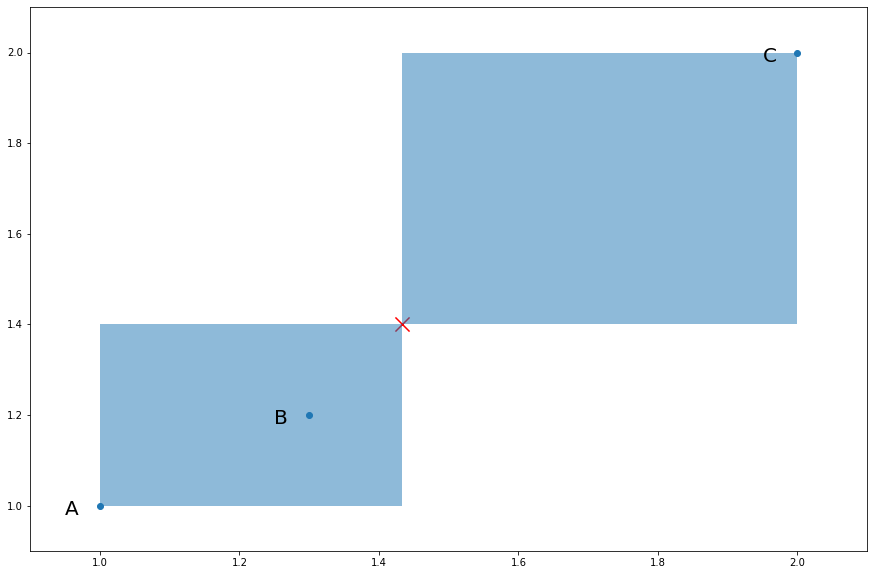

In [22]:
import matplotlib.pyplot as plt
fig=plt.figure()
ax = fig.add_subplot()
ax.set_ylim(ymin=0.9,ymax=2.1)
ax.set_xlim(xmin=0.9,xmax=2.1)
A=[1,1]
B=[1.3,1.2]
C=[2,2]
data=[A,B,C]
plt.scatter([x[0] for x in data],[x[1] for x in data])
midpoint=np.average(data,axis=0)
plt.scatter(midpoint[0],midpoint[1],marker='x',s=200, color='r')
plt.annotate('A', (A[0]-0.05,A[1]-0.02), fontsize=20)
plt.annotate('B', (B[0]-0.05,B[1]-0.02), fontsize=20)
plt.annotate('C', (C[0]-0.05,C[1]-0.02), fontsize=20)
rect = plt.Rectangle(A,midpoint[0]-A[0],midpoint[1]-A[1],alpha=0.5)
ax.add_patch(rect)
rect = plt.Rectangle(midpoint,C[0]-midpoint[0],C[1]-midpoint[1],alpha=0.5)
ax.add_patch(rect)
fig.set_size_inches(15, 10)
plt.show()

In [2]:
from pandas import DataFrame as DF
import numpy as np
domain_mapping, data, dim_names = xml_to_dict("Dataset\\prototypes.xml")
domain_mapping, data, dim_names = xml_to_dict("Dataset\\exemplars.xml", domain_mapping=domain_mapping, data=data, dimension_names=dim_names)
domain_mapping, data, dim_names = less_dimensions(domain_mapping, data, dim_names,threshold=10)
space.init(len(dim_names), domain_mapping, dim_names)
concepts=form_supercategories(data)

print(domain_mapping)
data=np.zeros((7,18))
domains=[domain_n for domain in [[dom for _ in range(len(domain_mapping[dom]))] for dom in domain_mapping] for domain_n in domain]
data=[]
for concept in concepts:
    #print(concepts[concept])
    conceptdata=[sum([1 if not example[i]==float('inf') else 0 for example in concepts[concept]]) for i in range(len(dim_names))]
    data.append(conceptdata+[len(concepts[concept])])
#df=DF(data,index=[concept for concept in concepts],columns=[domains,dim_names])

df=DF(data,index=[concept for concept in concepts],columns=[domains+['n examples'],dim_names+['n examples']])
df

owl is inconsistent
bat is inconsistent
salmon is inconsistent
spider is inconsistent
Sea_Turtle_Dermochelys_Choriacea is inconsistent
Sockeye_Salmon is inconsistent
Golden_Trout is inconsistent
thin_leg_spider is inconsistent
little_brown_bat is inconsistent
trachemys_turtle is inconsistent
{'locomotion': [0, 1], 'location': [2, 3, 4, 5], 'size': [6, 7, 8], 'color': [9, 10, 11], 'n_leg': [12], 'n_wing': [13], 'n_beak': [14], 'n_tail': [15], 'n_ear': [16]}


locomotion       location                                 size      \
            movement speed humidity temperature altitude vegetation    x   y   
mammal            43    43       40          40       40         40   50  50   
bird              15    15        9           9        9          9   15  15   
insect             5     5        6           6        6          6    7   7   
arthropod          2     2        2           2        2          2    2   2   
reptile            7     7        6           6        6          6    7   7   
fish               5     5        5           5        5          5    5   5   
mollusk            6     6        4           4        4          4    4   4   

              color              n_leg      n_wing      n_beak      n_tail  \
            z     l   a   b number_leg number_wing number_beak number_tail   
mammal     50    46  46  46         42           1           0          29   
bird       15    12  12  12          8          11          12           0   
insect      7     5   5   5          4           1           0           0   
arthropod   2     2   2   2          1           0           0           0   
reptile     7     7   7   7          3           0           0           1   
fish        5     2   2   2          0           0           0           1   
mollusk     4     4   4   4          0           0           0           0   

               n_ear n examples  
          number_ear n examples  
mammal            11         55  
bird               0         15  
insect             0          7  
arthropod          0          2  
reptile            0          7  
fish               0          5  
mollusk            0          7

owl is inconsistent
bat is inconsistent
salmon is inconsistent
spider is inconsistent
Sea_Turtle_Dermochelys_Choriacea is inconsistent
Sockeye_Salmon is inconsistent
Golden_Trout is inconsistent
thin_leg_spider is inconsistent
little_brown_bat is inconsistent
trachemys_turtle is inconsistent
{'target': 'bird', 'point': [6.310989295358734, 21.746095181455637, 52.11754998247107, -14.738236741811544, 48.14332143161095, 27.939425665955746, 34.50371606054222, 133.98613130304022, 46.00974682559649, inf, inf, inf, inf, 2.0, 1.0, inf, inf], 'n': 54}


Example:

C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 somebird54

learnt

naiveBig

naiveSmall

known

cheated:

cheated2
beep
beep
beep
beep
beep
beep
beep
beep
beep
beep
beep
beep
beep


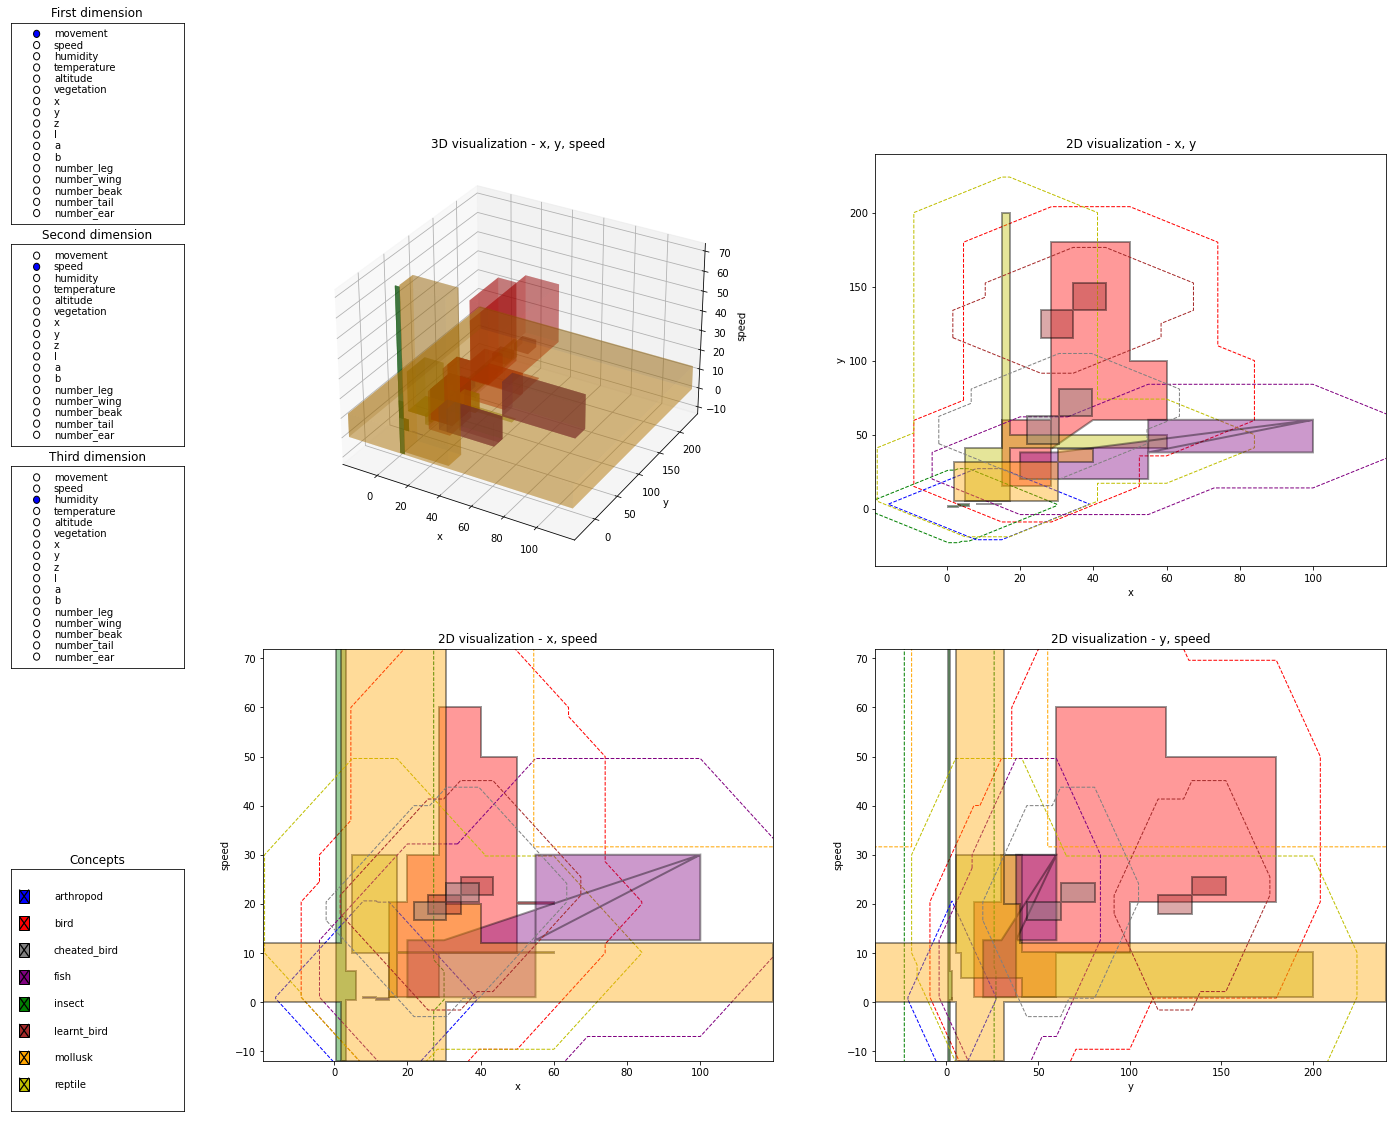

learnt 0.7459091298378622
small 0.45454545454545453
big 0.7250366042308957
known 0.963855421686747
cheated 0.6576518270407344


In [1]:
from example import generate
generate()

In [80]:
from pandas import DataFrame as DF
import numpy as np
data=np.zeros(5)
apmax=np.array([0.753,1.0,1.0,0.143,0.678])
apmin=np.array([0.092,0.535,0.098,0.143,0.122])
apavg=np.array([0.284,0.813,0.412,0.143,0.360])
apbmax=np.array([0.923,1.0,1.0,0.5,0.926])
apbmin=np.array([0.354,0.873,0.353,0.5,0.454])
apbavg=np.array([0.626,0.957,0.694,0.5,0.671])
cemax=np.array([1.970,1.796,1.878,2.074,1.891])
cemin=np.array([1.405,1.796,1.381,1.831,1.419])
ceavg=np.array([1.770,1.796,1.727,1.995,1.709])

data=np.array([apmax,apmin,apavg,apbmax,apbmin,apbavg,cemax,cemin,ceavg])

indices=[['AP','AP','AP','AP_balanced','AP_balanced','AP_balanced','CE','CE','CE'],['max','min','avg','max','min','avg','max','min','avg']]

df=DF(data,index=indices,columns=['learnt','known','naive_small','naive_big','cheated'])
df

learnt  known  naive_small  naive_big  cheated
AP          max   0.753  1.000        1.000      0.143    0.678
            min   0.092  0.535        0.098      0.143    0.122
            avg   0.284  0.813        0.412      0.143    0.360
AP_balanced max   0.923  1.000        1.000      0.500    0.926
            min   0.354  0.873        0.353      0.500    0.454
            avg   0.626  0.957        0.694      0.500    0.671
CE          max   1.970  1.796        1.878      2.074    1.891
            min   1.405  1.796        1.381      1.831    1.419
            avg   1.770  1.796        1.727      1.995    1.709

In [82]:
1/7

0.14285714285714285

In [ ]:
learnt
max 0.9231381034922005 ( somebird7 )
min 0.35367035430134164 ( somebird73 )
avg 0.6263778425356292
naive big
max 0.5
min 0.5
avg 0.5
naive small
max 1.0
min 0.3534025986701852
avg 0.6940079211522474
known
max 1.0
min 0.8727272727272727
avg 0.9574582997658447
cheated
max 0.9261836187961795
min 0.45416653523899386
avg 0.6714850626577489


(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.5)


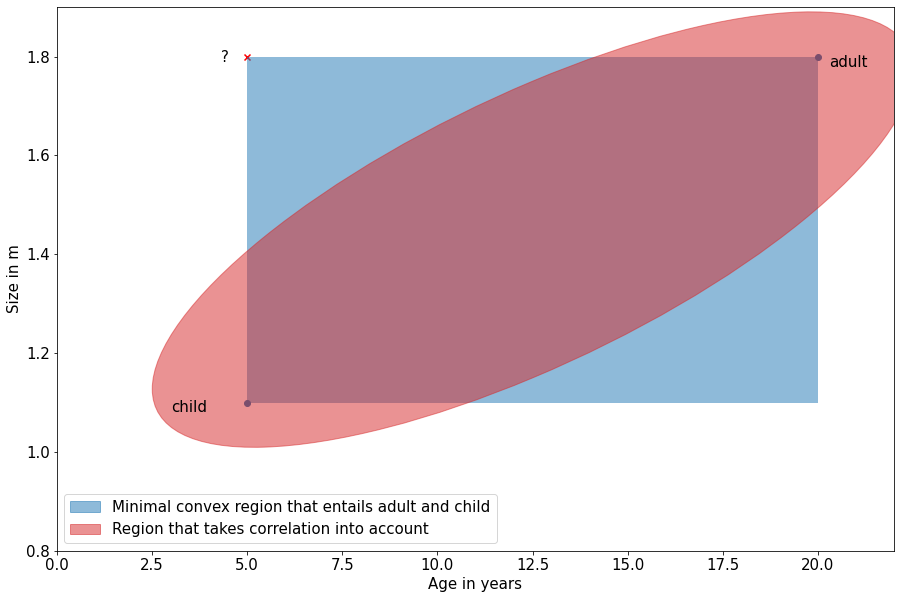

In [75]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
x=[5,20]
y=[1.1,1.8]
fig=plt.figure()
ax = fig.add_subplot()
ax.set_ylabel('Size in m',fontsize=15)
ax.set_xlabel('Age in years',fontsize=15)
plt.scatter(x,y)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
ax.annotate('child',(x[0]-2,y[0]-0.02),fontsize=15)
ax.annotate('adult',(x[1]+0.3,y[1]-0.02),fontsize=15)
ax.annotate('?',(4.3,1.79),fontsize=15)
rect = plt.Rectangle((5,1.1),15,0.7,alpha=0.5)
ax.add_patch(rect)
ax.set_ylim(ymin=0.8,ymax=1.9)
ax.set_xlim(xmin=0,xmax=22)
col=tuple(list(colors.to_rgba('tab:blue'))[:3]+[0.5])
plt.scatter([5.0],[1.8],marker='x',color='r')
print(col)
el = mpatches.Ellipse(((x[1]+x[0])/2,(y[1]+y[0])/2), width=20, height=0.6, angle=1.85, color=tuple(list(colors.to_rgba('tab:red'))[:3]+[0.5]))  # in data coordinates!
ax.add_patch(el)
blue_patch = mpatches.Patch(color=col, label='Minimal convex region that entails adult and child')
red_patch = mpatches.Patch(color=tuple(list(colors.to_rgba('tab:red'))[:3]+[0.5]), label='Region that takes correlation into account')
plt.legend(handles=[blue_patch,red_patch],fontsize=15)
fig.set_size_inches(15, 10)
plt.show()

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.5)


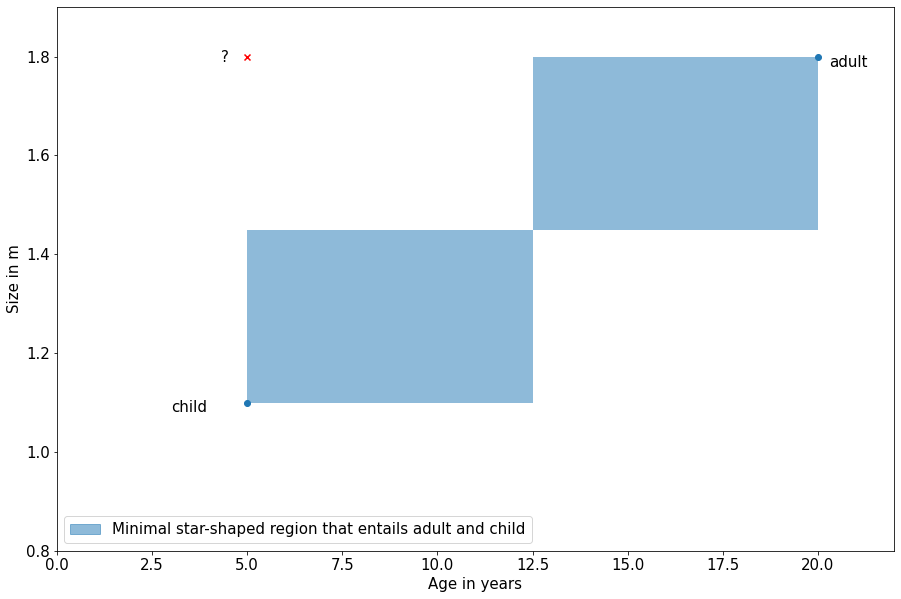

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
x=[5,20]
y=[1.1,1.8]
fig=plt.figure()
ax = fig.add_subplot()
ax.set_ylabel('Size in m',fontsize=15)
ax.set_xlabel('Age in years',fontsize=15)
plt.scatter(x,y)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
ax.annotate('child',(x[0]-2,y[0]-0.02),fontsize=15)
ax.annotate('adult',(x[1]+0.3,y[1]-0.02),fontsize=15)
ax.annotate('?',(4.3,1.79),fontsize=15)
rect = plt.Rectangle((12.5,1.45),7.5,0.35,alpha=0.5)
ax.add_patch(rect)
rect = plt.Rectangle((5,1.1),7.5,0.35,alpha=0.5)
ax.add_patch(rect)
ax.set_ylim(ymin=0.8,ymax=1.9)
ax.set_xlim(xmin=0,xmax=22)
col=tuple(list(colors.to_rgba('tab:blue'))[:3]+[0.5])
plt.scatter([5.0],[1.8],marker='x',color='r')
print(col)
#el = mpatches.Ellipse(((x[1]+x[0])/2,(y[1]+y[0])/2), width=20, height=0.6, angle=1.85, color=tuple(list(colors.to_rgba('tab:red'))[:3]+[0.5]))  # in data coordinates!
#ax.add_patch(el)
blue_patch = mpatches.Patch(color=col, label='Minimal star-shaped region that entails adult and child')
#red_patch = mpatches.Patch(color=tuple(list(colors.to_rgba('tab:red'))[:3]+[0.5]), label='Region that takes correlation into account')
plt.legend(handles=[blue_patch],fontsize=15,loc='lower left')
fig.set_size_inches(15, 10)
plt.show()

In [76]:
import numpy as np
data=[3,10]
np.std(data)

3.5

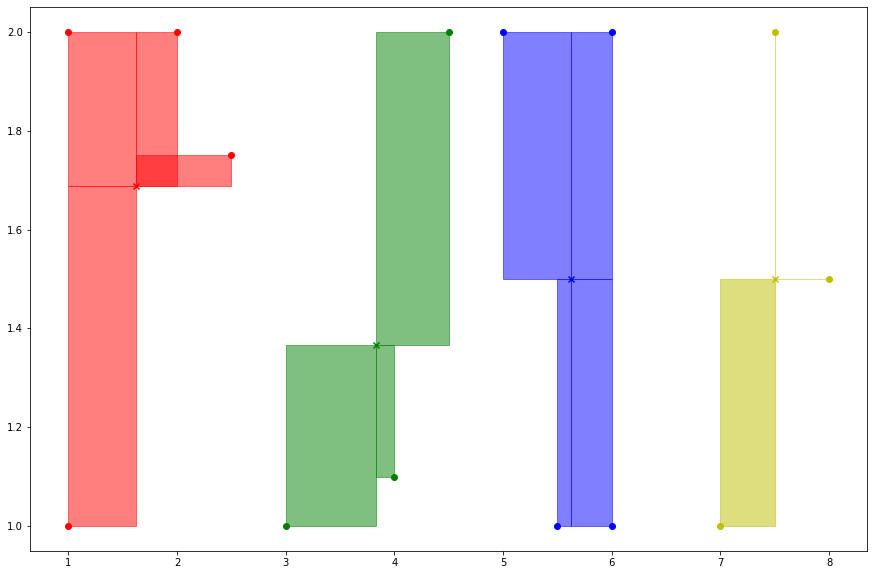

In [40]:
colors=['r','g','b','y']

def get_midpoint(x):
    return (np.average([xi[0] for xi in x]),np.average([xi[1] for xi in x]))
fig=plt.figure()

ax = fig.add_subplot()

c1=[[1,1],[1,2],[2,2],[2.5,1.75]]
c2=[(3,1),(4,1.1),(4.5,2)]
c3=[(5.5,1),(5,2),(6,2),(6,1)]
c4=[(7,1),(8,1.5),(7.5,2)]

for c,color in zip([c1,c2,c3,c4],['r','g','b','y']):
    midpoint=get_midpoint(c)
    plt.scatter(midpoint[0],midpoint[1],marker='x',color=color)
    for point in c:
        anchor=(min(midpoint[0],point[0]),min(midpoint[1],point[1]))
        width=max(point[0]-anchor[0],midpoint[0]-anchor[0])
        height=max(point[1]-anchor[1],midpoint[1]-anchor[1])
        rect = plt.Rectangle(anchor,width,height,alpha=0.5,color=color)
        ax.add_patch(rect)
    plt.scatter([p[0] for p in c],[p[1] for p in c],color=color)
fig.set_size_inches(15, 10)

plt.show()

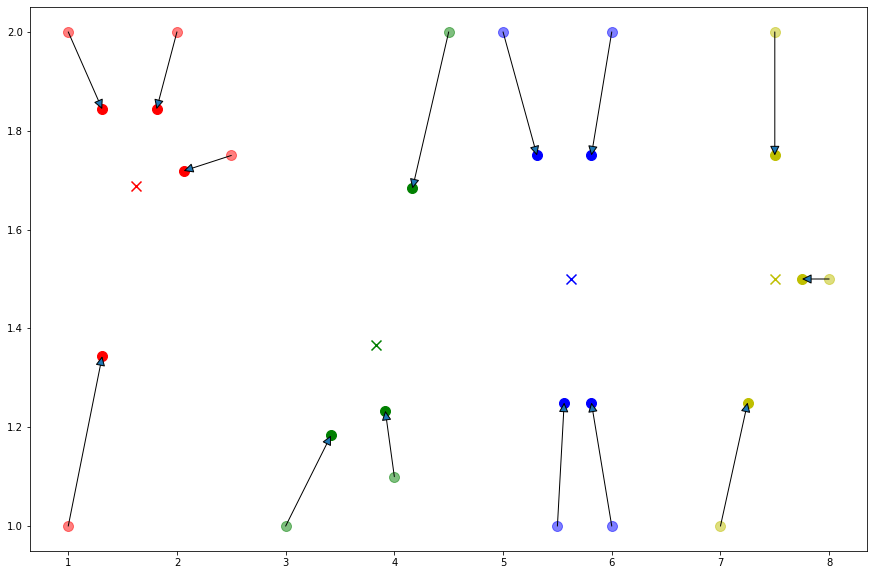

[[[1.3125, 1.34375], [1.3125, 1.84375], [1.8125, 1.84375], [2.0625, 1.71875]], [[3.416666666666667, 1.1833333333333331], [3.916666666666667, 1.2333333333333334], [4.166666666666667, 1.6833333333333331]], [[5.5625, 1.25], [5.3125, 1.75], [5.8125, 1.75], [5.8125, 1.25]], [[7.25, 1.25], [7.75, 1.5], [7.5, 1.75]]]


In [41]:
fig=plt.figure()

ax = fig.add_subplot()
data=[]
for c,color in zip([c1,c2,c3,c4],colors):
    midpoint=get_midpoint(c)
    plt.scatter(midpoint[0],midpoint[1],marker='x',color=color, s=100)
    data.append([])
    for point in c:
        anchor=(min(midpoint[0],point[0]),min(midpoint[1],point[1]))
        width=max(point[0]-anchor[0],midpoint[0]-anchor[0])
        height=max(point[1]-anchor[1],midpoint[1]-anchor[1])
        prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",shrinkA=0,shrinkB=0)
        plt.annotate("", xy=((midpoint[0]+point[0])/2,(midpoint[1]+point[1])/2), xytext=(point[0],point[1]), arrowprops=prop)
        plt.scatter((midpoint[0]+point[0])/2,(midpoint[1]+point[1])/2, color=color, s=100)
        data[-1].append([(midpoint[0]+point[0])/2,(midpoint[1]+point[1])/2])

    plt.scatter([p[0] for p in c],[p[1] for p in c],color=color,alpha=0.5,s=100)
fig.set_size_inches(15, 10)

plt.show()
print(data)

[[1.3125, 1.34375], [1.3125, 1.84375], [1.8125, 1.84375], [2.0625, 1.71875]]
[[3.416666666666667, 1.1833333333333331], [3.916666666666667, 1.2333333333333334], [4.166666666666667, 1.6833333333333331]]
[[5.5625, 1.25], [5.3125, 1.75], [5.8125, 1.75], [5.8125, 1.25]]
[[7.25, 1.25], [7.75, 1.5], [7.5, 1.75]]


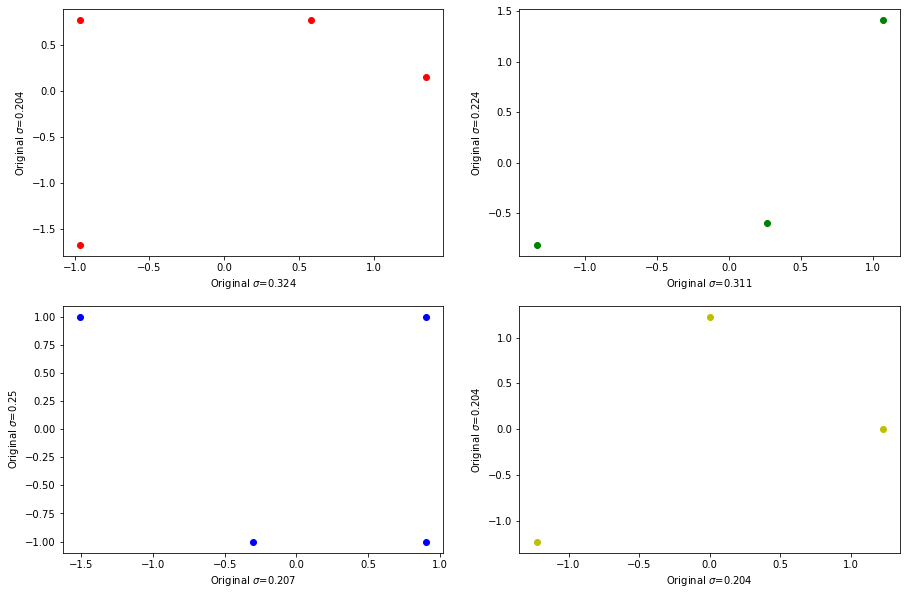

In [42]:
def normalize_to_standard_score(points):
    #calculate means af defined values for each dimension
    means=[]
    for dimension in zip(*points):
        values=[x for x in dimension if not (x==float('inf') or np.isnan(x))]
        if len(values):
            means.append(sum(values)/len(values))
        else:
            means.append(0)
    means=np.array(means)
    
    #copy data, replace missing values by mean
    normalized_data=np.zeros(np.shape(points))
    for j in range(len(points)):
        for i in range(len(points[j])):
            normalized_data[j][i]=points[j][i] if not (points[j][i]==float('inf') or np.isnan(points[j][i])) else means[i]
            
    #calculate the std in each dimension
    stds=np.std(normalized_data, axis = 0)
    #stds of 0 zero are considered to be inf, in order to avoid division by zero
    stds=np.array([std if not std==0 else float('inf') for std in stds])
    #normalize data to standard score
    normalized_data = [(point-means)/stds for point in normalized_data]
    #for the inverse function a std of zero is ok again, inverse fun not implemented, only "amount" of one std
    stds=np.array([std if not std==float('inf') else 0 for std in stds])
    #inverse_fun = lambda x:x*stds+means
    return stds, np.array(normalized_data)

#concepts=[[[1.1666666666666665, 1.3333333333333335], [1.1666666666666665, 1.8333333333333335], [1.6666666666666665, 1.8333333333333335]], [[3.333333333333333, 1.1666666666666665], [3.833333333333333, 1.1666666666666665], [3.833333333333333, 1.6666666666666665]], [[5.25, 1.25], [5.75, 1.5], [5.5, 1.75]]]
concepts=data
allstds=[]
data_all=[]
stds_all=[]
fig=plt.figure()
for i,concept,c in zip(range(len(concepts)),concepts,colors):
    print(concept)
    stds, norm_data=normalize_to_standard_score(concept)
    ax = fig.add_subplot(221+i)
    plt.scatter([p[0] for p in norm_data],[p[1] for p in norm_data],color=c)
    plt.xlabel('Original 'r'$\sigma$='+str(stds[0])[:5])
    plt.ylabel('Original 'r'$\sigma$='+str(stds[1])[:5])
    stds_all.append(stds)
    data_all.append(norm_data)
    allstds.append(stds)
fig.set_size_inches(15, 10)
plt.show()

In [215]:
2.5*0.324

0.81

[[-0.96225045 -0.96225045  0.57735027  1.34715063]
 [-1.67748427  0.76249285  0.76249285  0.15249857]]
[[1.33333333 0.50870497]
 [0.50870497 1.33333333]]
[0.82462837 1.8420383 ]
1
[-0.70710678 -0.70710678]
xmax 1.5471506281091267
[0, 0]
center: (0, 0)
dir: (-0.9596974266487803, -0.9596974266487805)
[[-1.33630621  0.26726124  1.06904497]
 [-0.81537425 -0.59299945  1.4083737 ]]
[[1.5        1.21835936]
 [1.21835936 1.5       ]]
[2.71835936 0.28164064]
0
[0.70710678 0.70710678]
xmax 1.3658386165259173
[0, 0]
center: (0, 0)
dir: (1.1658386165259174, 1.165838616525917)
[[-0.30151134 -1.50755672  0.90453403  0.90453403]
 [-1.          1.          1.         -1.        ]]
[[ 1.33333333 -0.40201513]
 [-0.40201513  1.33333333]]
[0.93131821 1.73534846]
1
[ 0.70710678 -0.70710678]
xmax 1.131490327227561
[0, 0]
center: (0, 0)
dir: (0.931490327227561, -0.9314903272275611)
[[-1.22474487  1.22474487  0.        ]
 [-1.22474487  0.          1.22474487]]
[[1.5  0.75]
 [0.75 1.5 ]]
[2.25 0.75]
0
[0.70710

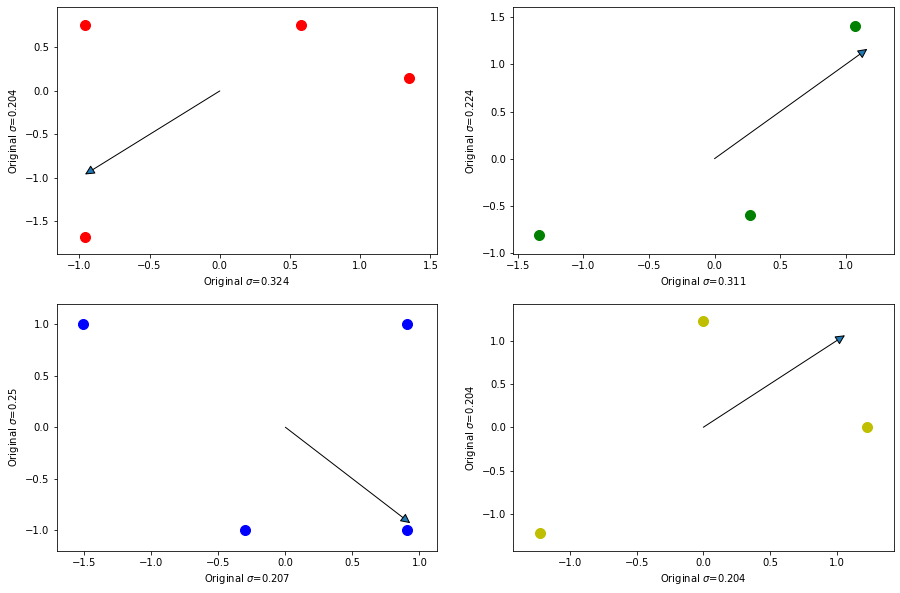

In [43]:
fig=plt.figure()

pcs=[]
for i,c,color in zip(range(len(data_all)),data_all,colors):
    ax = fig.add_subplot(221+i)
    inp=np.array(c).T
    print(inp)
    covmat=np.cov(inp)
    print(covmat)
    val,vec=np.linalg.eig(covmat)
    print(val)
    print(np.argmax(val))
    print(vec[:,np.argmax(val)])
    pc=vec[:,np.argmax(val)]*max(val)**(1/2)
    midpoint=[0,0]
    print('xmax',max([p[0] for p in c]+[midpoint[0]+pc[0]])+0.2)
    ax.set_ylim(ymin=min([p[1] for p in c]+[midpoint[1]+pc[1]])-0.2,ymax=max([p[1] for p in c]+[midpoint[1]+pc[1]])+0.2)
    ax.set_xlim(xmin=min([p[0] for p in c]+[midpoint[0]+pc[0]])-0.2,xmax=max([p[0] for p in c]+[midpoint[0]+pc[0]])+0.2)
    plt.scatter([p[0] for p in c],[p[1] for p in c],color=color, s=100)
    print(midpoint)
    print('center:',(midpoint[0],midpoint[1]))
    print('dir:',(midpoint[0]+pc[0],midpoint[1]+pc[1]))
    prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",shrinkA=0,shrinkB=0)
    pcs.append(pc)
    plt.annotate("", xy=(midpoint[0]+pc[0],midpoint[1]+pc[1]), xytext=(int(midpoint[0]),int(midpoint[1])), arrowprops=prop)
    plt.xlabel('Original 'r'$\sigma$='+str(stds_all[i][0])[:5])
    plt.ylabel('Original 'r'$\sigma$='+str(stds_all[i][1])[:5])
fig.set_size_inches(15, 10)
pcs=np.array(pcs)
plt.show()
    

xmax 1.5471506281091267
[0, 0]
center: (0, 0)
dir: (-0.9596974266487803, -0.9596974266487805)
xmax 1.269044967649698
[0, 0]
center: (0, 0)
dir: (-1.1658386165259174, -1.165838616525917)
xmax 1.131490327227561
[0, 0]
center: (0, 0)
dir: (0.931490327227561, -0.9314903272275611)
xmax 1.424744871391589
[0, 0]
center: (0, 0)
dir: (-1.060660171779821, -1.060660171779821)


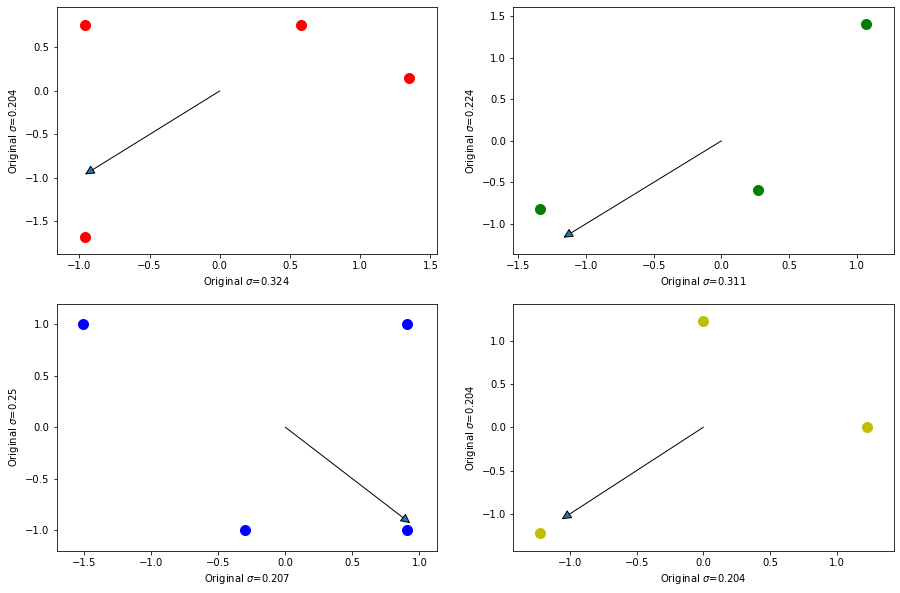

In [44]:
pcs=brush_vectors(pcs)
fig=plt.figure()

for i,c,color in zip(range(len(data_all)),data_all,colors):
    ax = fig.add_subplot(221+i)
    pc=pcs[i]
    midpoint=[0,0]
    print('xmax',max([p[0] for p in c]+[midpoint[0]+pc[0]])+0.2)
    ax.set_ylim(ymin=min([p[1] for p in c]+[midpoint[1]+pc[1]])-0.2,ymax=max([p[1] for p in c]+[midpoint[1]+pc[1]])+0.2)
    ax.set_xlim(xmin=min([p[0] for p in c]+[midpoint[0]+pc[0]])-0.2,xmax=max([p[0] for p in c]+[midpoint[0]+pc[0]])+0.2)
    plt.scatter([p[0] for p in c],[p[1] for p in c],color=color, s=100)
    print(midpoint)
    print('center:',(midpoint[0],midpoint[1]))
    print('dir:',(midpoint[0]+pc[0],midpoint[1]+pc[1]))
    prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",shrinkA=0,shrinkB=0)
    plt.annotate("", xy=(midpoint[0]+pc[0],midpoint[1]+pc[1]), xytext=(int(midpoint[0]),int(midpoint[1])), arrowprops=prop)
    plt.xlabel('Original 'r'$\sigma$='+str(stds_all[i][0])[:5])
    plt.ylabel('Original 'r'$\sigma$='+str(stds_all[i][1])[:5])
fig.set_size_inches(15, 10)
plt.show()

[-0.5636764719317395, -1.02942163554552]


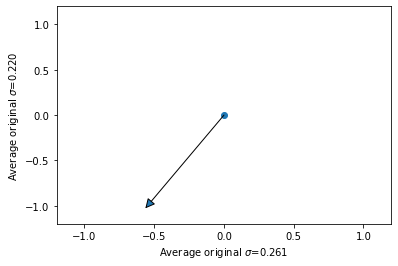

In [45]:
background_knowledge=[np.average([pc[i] for pc in pcs]) for i in range(len(pcs[0]))]
fig=plt.figure()
ax = fig.add_subplot()
print(background_knowledge)
prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",shrinkA=0,shrinkB=0)
plt.scatter(0,0)
plt.annotate("", xy=(0+background_knowledge[0],0+background_knowledge[1]), xytext=(0,0), arrowprops=prop)
ax.set_ylim(ymin=-1.2,ymax=1.2)
ax.set_xlim(xmin=-1.2,xmax=1.2)
avg_stds=[np.average([stds_all[i][j] for i in range(len(stds_all))]) for j in [0,1]]
plt.xlabel('Average original 'r'$\sigma$='+str(avg_stds[0])[:5])
plt.ylabel('Average original 'r'$\sigma$='+str(avg_stds[1])[:5])
plt.show()

[-0.1476800654281012, -0.22747380163165623]


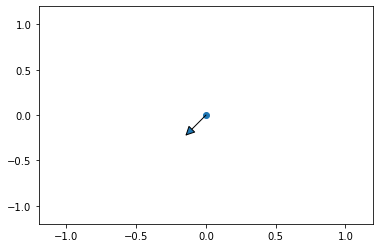

In [46]:
background_knowledge=[x*y for x,y in zip(background_knowledge,avg_stds)]
fig=plt.figure()
ax = fig.add_subplot()
print(background_knowledge)
prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",shrinkA=0,shrinkB=0)
plt.scatter(0,0)
plt.annotate("", xy=(0+background_knowledge[0],0+background_knowledge[1]), xytext=(0,0), arrowprops=prop)
ax.set_ylim(ymin=-1.2,ymax=1.2)
ax.set_xlim(xmin=-1.2,xmax=1.2)
avg_stds=[np.average([stds_all[i][j] for i in range(len(stds_all))]) for j in [0,1]]
plt.show()

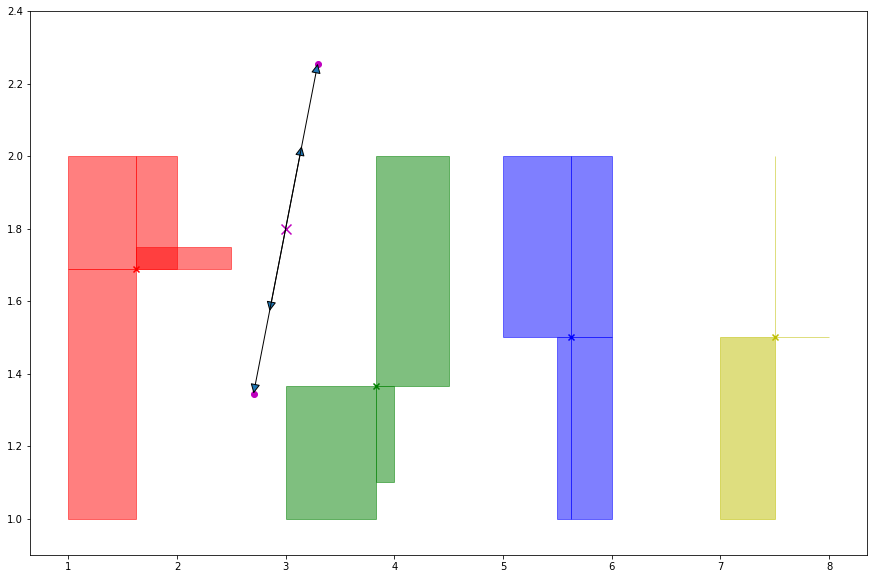

In [48]:
import matplotlib.pyplot as plt
import numpy as np

colors=['r','g','b','y']

def get_midpoint(x):
    return (np.average([xi[0] for xi in x]),np.average([xi[1] for xi in x]))
fig=plt.figure()

ax = fig.add_subplot()
ax.set_ylim(ymin=0.9,ymax=2.4)
c1=[[1,1],[1,2],[2,2],[2.5,1.75]]
c2=[(3,1),(4,1.1),(4.5,2)]
c3=[(5.5,1),(5,2),(6,2),(6,1)]
c4=[(7,1),(8,1.5),(7.5,2)]


for c,color in zip([c1,c2,c3,c4],['r','g','b','y']):
    midpoint=get_midpoint(c)
    plt.scatter(midpoint[0],midpoint[1],marker='x',color=color)
    for point in c:
        anchor=(min(midpoint[0],point[0]),min(midpoint[1],point[1]))
        width=max(point[0]-anchor[0],midpoint[0]-anchor[0])
        height=max(point[1]-anchor[1],midpoint[1]-anchor[1])
        rect = plt.Rectangle(anchor,width,height,alpha=0.5,color=color)
        ax.add_patch(rect)
    #plt.scatter([p[0] for p in c],[p[1] for p in c],color=color)
    
prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",shrinkA=0,shrinkB=0)
plt.annotate("", xy=(3+background_knowledge[0],1.8+background_knowledge[1]), xytext=(3,1.8), arrowprops=prop)
plt.annotate("", xy=(3+background_knowledge[0]*2,1.8+background_knowledge[1]*2), xytext=(3,1.8), arrowprops=prop)
plt.annotate("", xy=(3-background_knowledge[0],1.8-background_knowledge[1]), xytext=(3,1.8), arrowprops=prop)
plt.annotate("", xy=(3-background_knowledge[0]*2,1.8-background_knowledge[1]*2), xytext=(3,1.8), arrowprops=prop)
plt.scatter(3+background_knowledge[0]*2,1.8+background_knowledge[1]*2,color='m')
plt.scatter(3-background_knowledge[0]*2,1.8-background_knowledge[1]*2,color='m')
plt.scatter(3,1.8,marker='x',color='m',s=100)


fig.set_size_inches(15, 10)

plt.show()

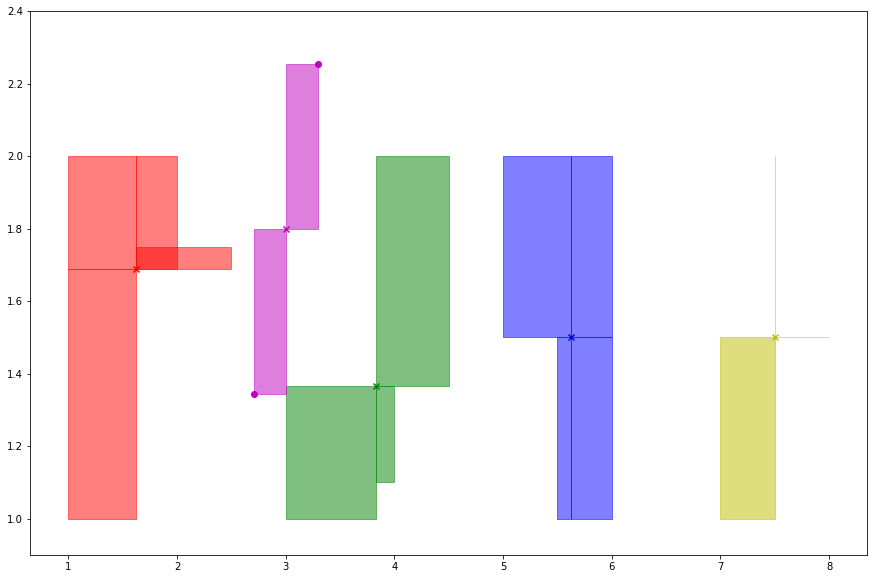

In [49]:
colors=['r','g','b','y']

def get_midpoint(x):
    return (np.average([xi[0] for xi in x]),np.average([xi[1] for xi in x]))
fig=plt.figure()

ax = fig.add_subplot()
ax.set_ylim(ymin=0.9,ymax=2.4)


for c,color in zip([c1,c2,c3,c4],['r','g','b','y']):
    midpoint=get_midpoint(c)
    plt.scatter(midpoint[0],midpoint[1],marker='x',color=color)
    for point in c:
        anchor=(min(midpoint[0],point[0]),min(midpoint[1],point[1]))
        width=max(point[0]-anchor[0],midpoint[0]-anchor[0])
        height=max(point[1]-anchor[1],midpoint[1]-anchor[1])
        rect = plt.Rectangle(anchor,width,height,alpha=0.5,color=color)
        ax.add_patch(rect)
    #plt.scatter([p[0] for p in c],[p[1] for p in c],color=color)
    
prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",shrinkA=0,shrinkB=0)
plt.scatter(3+background_knowledge[0]*2,1.8+background_knowledge[1]*2,color='m')
plt.scatter(3-background_knowledge[0]*2,1.8-background_knowledge[1]*2,color='m')
plt.scatter(3,1.8,marker='x',color='m')
rect = plt.Rectangle((3-background_knowledge[0]*2,1.8-background_knowledge[1]*2),background_knowledge[0]*2,background_knowledge[1]*2,alpha=0.5,color='m')
ax.add_patch(rect)
rect = plt.Rectangle((3,1.8),background_knowledge[0]*2,background_knowledge[1]*2,alpha=0.5,color='m')
ax.add_patch(rect)

fig.set_size_inches(15, 10)

plt.show()

In [ ]:
import example
import cs.cs as space
example.generate('Swan')
print(space._concepts['birdfromSwan'])

In [2]:
import sys
sys.path.append("conceptual_spaces")
import cs.cs as space
from cs.weights import Weights
from cs.cuboid import Cuboid
from cs.core import Core
from cs.core import from_cuboids
from cs.concept import Concept
space.init(3, {'a':[0],'b':[1],'c':[2]})
'''cub=Cuboid([0,0,float('-inf')],[1,1,float('inf')],{'a':[0],'b':[1]})
core=Core([cub],{'a':[0],'b':[1]})
weights=Weights(space._def_dom_weights,space._def_dim_weights)
concept=Concept(core,1,1,weights)
concept.membership_of([2,float('inf'),1])'''
data={'A':{'point':[0,5,10]},'B':{'point':[10,10,0]},'C':{'point':[5,0,5]}}
norm=normalize_data(data)
print(data)
print(norm([10,0,15]))

NameError: name 'normalize_data' is not defined

In [ ]:
del(data[]

In [ ]:
from sklearn.metrics import average_precision_score
y_true=[1,0,1,0]
y_score=[1,1,0.5,0.3]
average_precision_score(y_true,y_score)

In [5]:
import _pickle as pkl
import warnings
warnings.filterwarnings("ignore")
C=0.05
#read concepts from prototypes and exemplars
domain_mapping, data, dim_names = xml_to_dict("Dataset\\prototypes.xml")
domain_mapping, data, dim_names = xml_to_dict("Dataset\\exemplars.xml", domain_mapping=domain_mapping, data=data, dimension_names=dim_names)

space.init(len(dim_names), domain_mapping, dim_names)

for i, dim_name in zip(range(len(dim_names)),dim_names):
    print(dim_name+':',i)
#norm=normalize_data(data, domain_mapping)
concepts=form_supercategories(data)

aps={}
random.seed(a=1)

data={}
with open('samples.txt', 'rb') as file:
    data=pkl.load(file)

print(data.keys())

for family in data:
    if len(concepts[family])-1:
        for example in data[family]:
            aps.update(evaluate_example(example, data, concepts, domain_mapping, dim_names, method=two_cubs_PCA, testdata=testdata, criterion=complete_categorical_cross_entropy))
    
ap=[x[0] for x in aps.values()]
diff_ap=[x[0]-x[1] for x in aps.values()]
print(max(diff_ap))
print(min(diff_ap))
print(sum(diff_ap)/len(diff_ap))
print(list(aps.keys())[np.argmax(diff_ap)])

movement: 0
speed: 1
number_horn: 2
humidity: 3
temperature: 4
altitude: 5
vegetation: 6
x: 7
y: 8
z: 9
l: 10
a: 11
b: 12
number_leg: 13
number_fur: 14
number_wing: 15
number_beak: 16
number_hump: 17
number_shell: 18
number_claw: 19
number_mouth: 20
number_tail: 21
number_fin: 22
number_neck: 23
number_crane: 24
number_ear: 25
number_eye: 26
number_feeler: 27
number_proboscis: 28
number_tusk: 29
number_whisker: 30
number_pouch: 31
number_sting: 32
number_antler: 33
number_tentacle: 34
number_tongue: 35
number_antenna: 36
number_stripe: 37
number_spot: 38
number_nose: 39
number_collar: 40
number_eye ring: 41
number_stub: 42
number_foot: 43
number_crest: 44
dict_keys(['mammal', 'bird', 'insect', 'arthropod', 'reptile', 'fish', 'mollusk', 'arachnid'])


TypeError: list indices must be integers or slices, not str

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[0.00000000e+00 4.00000000e+00 0.00000000e+00 2.80731443e-32]
5.0
[-8. -8. -8. -8.]


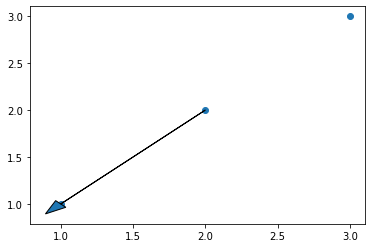

In [25]:
import numpy as np
import matplotlib.pyplot as plt

data=np.array([[1,1,1,1],[2,2,2,2],[3,3,3,3]]).T
covmat=np.cov(data)
print(covmat)
val,vec=np.linalg.eig(covmat)

print(val)
print(np.sqrt(sum((vec[:,1]*5)**2)))
print(vec[:,1]*val[1]**2)
plt.scatter(data[0,:],data[1,:])
pc=vec[:,1]*val[1]**(1/2)
plt.arrow(np.mean(data[0,:]),np.mean(data[1,:]),pc[0],pc[1],head_width=0.1,head_starts_at_zero=False)
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")
C=0.05
#read concepts from prototypes and exemplars
domain_mapping, data, dim_names = xml_to_dict("Dataset\\prototypes.xml")
domain_mapping, data, dim_names = xml_to_dict("Dataset\\exemplars.xml", domain_mapping=domain_mapping, data=data, dimension_names=dim_names)

space.init(len(dim_names), domain_mapping, dim_names)

for i, dim_name in zip(range(len(dim_names)),dim_names):
    print(dim_name+':',i)
#norm=normalize_data(data, domain_mapping)
concepts=form_supercategories(data)

aps={}
example='Swan'    
target=data[example]['supercategory']



for family in trainset:
    family_into_space(family, trainset[family])
sibblings = [concept for concept in space._concepts if not concept==target]

trainset={concept:concepts[concept] for concept in concepts if not concept==target}


c=two_cubs_PCA(data[example]['point'], sibblings)
#c=one_shot(data[example]['point'], method=two_cubs_PCA,sibblings=sibblings,name=target+'from'+example)
print(c)

In [ ]:
p_min1=[7.5290613359985885, 20.0, -inf, -inf, -inf, -inf, -inf, 50.95281816072975, 96.59377939868706, 41.92330715328025, 99.63258506183855, 0.0, -0.5618942895456218, 1.9993685562359478, -inf, 2.0, 1.0, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf]
p_max1=[8.0, 23.405080744562124, inf, inf, inf, inf, inf, 60.0, 100.0, 120.0, 100.0, 0.5936963890927721, 0.0, 2.0, inf, 2.0, 1.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
p_min2=[8.0, 16.594919255437876, -inf, -inf, -inf, -inf, -inf, 60.0, 100.0, 120.0, 100.0, -0.5936963890927721, 0.0, 2.0, -inf, 2.0, 1.0, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf]
p_max2=[8.47093866400141, 20.0, inf, inf, inf, inf, inf, 69.04718183927025, 103.40622060131294, 198.07669284671977, 100.36741493816145, 0.0, 0.5618942895456218, 2.000631443764052, inf, 2.0, 1.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]

In [ ]:
for family in testdata:
    for datum in testdata[family]:
        if datum==[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 1.2991494295687187, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]:
            print(family)

In [ ]:
testdict={'A':[1,2,3],'B':[4],'C':[5]}
print(testdict.values())
print(list(testdict.values()))
liste=list(testdict.values())
reduce(lambda x,y: x+y,(liste))

In [ ]:
for datum in data:
    if not data[datum]['point'][16]==float('inf'):
        print(datum,data[datum]['point'][16])
for cuboid in space._concepts['bird']._core._cuboids:
    print(cuboid._p_min[16],cuboid._p_max[16])

In [ ]:
#test arbitrary concept

import xml.etree.ElementTree as ET
import os
import sys
sys.path.append("conceptual_spaces")
import cs.cs as space
from cs.weights import Weights
from cs.cuboid import Cuboid
from cs.core import Core
from cs.core import from_cuboids
from cs.concept import Concept

C=0.5
inf=float('inf')

domains={'A':[0],'B':[1],'C':[2]}
dimension_names=['a','b','c']
space.init(len(dimension_names),domains, dimension_names)


p_min=[0,0,float('-inf')]
p_max=[1,1,float('inf')]
c_example = Cuboid(p_min, p_max, {'A':[0],'B':[1]})

p_min=[float('-inf'),1,1]
p_max=[float('inf'),2,2]
c_example2 = Cuboid(p_min, p_max, {'B':[1],'C':[2]})

s_example = Core([c_example], domains)

weights=space._def_dom_weights
w_example = Weights(weights,space._def_dim_weights)
concept = Concept(s_example, 1.0, C, w_example)
'''
point=[inf,inf,0]

print()
print(concept.crisp_sample(10))'''

concept.membership_of([inf,inf,500])

In [ ]:
not True or (not False and True)

In [ ]:
#ap_learnt, ap_naive, ap_known, ap_cheated, ap_supercheated
diff_ap=[x[0] for x in aps.values()]
print('learnt')
print('max',max(diff_ap))
print('min',min(diff_ap))
print('avg',sum(diff_ap)/len(diff_ap))

print(list(aps.keys())[np.argmax(diff_ap)])

diff_ap=[x[1] for x in aps.values()]
print('naive big')
print('max',max(diff_ap))
print('min',min(diff_ap))
print('avg',sum(diff_ap)/len(diff_ap))

diff_ap=[x[2] for x in aps.values()]
print('known')
print('max',max(diff_ap))
print('min',min(diff_ap))
print('avg',sum(diff_ap)/len(diff_ap))

diff_ap=[x[3] for x in aps.values()]
print('cheated')
print('max',max(diff_ap))
print('min',min(diff_ap))
print('avg',sum(diff_ap)/len(diff_ap))

diff_ap=[x[4] for x in aps.values()]
print('supercheated')
print('max',max(diff_ap))
print('min',min(diff_ap))
print('avg',sum(diff_ap)/len(diff_ap))

diff_ap=[x[5] for x in aps.values()]
print('naive small')
print('max',max(diff_ap))
print('min',min(diff_ap))
print('avg',sum(diff_ap)/len(diff_ap))

print(list(aps.keys())[np.argmax(diff_ap)])

In [16]:
import warnings

warnings.filterwarnings("ignore")
C=0.05
#read concepts from prototypes and exemplars
domain_mapping, data, dim_names = xml_to_dict("Dataset\\prototypes.xml")
domain_mapping, data, dim_names = xml_to_dict("Dataset\\exemplars.xml", domain_mapping=domain_mapping, data=data, dimension_names=dim_names)

space.init(len(dim_names), domain_mapping, dim_names)

for i, dim_name in zip(range(len(dim_names)),dim_names):
    print(dim_name+':',i)
#norm=normalize_data(data, domain_mapping)
del(data['whale'])
concepts=form_supercategories(data)

random.seed(a=2)

testdata2={}
i=-1
for concept in ['mammal']:
    print(concept)
    i+=1
    conc=family_into_space(concept, concepts[concept],add=False)
    testdata2[concept]=[]
    for n in range(10):
        testdata2[concept]+=conc.crisp_sample(10)
        print(i,n*10)
        


movement: 0
speed: 1
number_horn: 2
humidity: 3
temperature: 4
altitude: 5
vegetation: 6
x: 7
y: 8
z: 9
l: 10
a: 11
b: 12
number_leg: 13
number_fur: 14
number_wing: 15
number_beak: 16
number_hump: 17
number_shell: 18
number_claw: 19
number_mouth: 20
number_tail: 21
number_fin: 22
number_neck: 23
number_crane: 24
number_ear: 25
number_eye: 26
number_feeler: 27
number_proboscis: 28
number_tusk: 29
number_whisker: 30
number_pouch: 31
number_sting: 32
number_antler: 33
number_tentacle: 34
number_tongue: 35
number_antenna: 36
number_stripe: 37
number_spot: 38
number_nose: 39
number_collar: 40
number_eye ring: 41
number_stub: 42
number_foot: 43
number_crest: 44
mammal
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 48.849924409898435, 54.11810373526963, 29.78995500419185, 2.3923917534897345, inf, inf, inf, inf, inf, inf, inf, 1.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
[inf, inf, inf, inf, inf, inf, inf, inf, inf,

In [17]:
samples_wo_whale=testdata.copy()
samples_wo_whale['mammal']=testdata2['mammal']

In [ ]:
#testdata!!


inf=float('inf')
testdata={'mammal': [[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 2.368159280074705, inf, inf, inf, inf, inf, inf, inf, 1.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [4.929329409955873, 29.816463404959396, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 3.360204773256867, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [4.452887102602035, 25.082323844389872, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 1.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [inf, inf, inf, 52.79717137963985, 11.102256224281124, 215.31568305778927, 32.04528669089865, inf, inf, inf, 71.67501743682662, 2.402745981196926, 10.564792800418434, inf, inf, inf, inf, inf, inf, inf, inf, 1.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [inf, inf, inf, inf, inf, inf, inf, 257.72568514405003, 416.3812656898092, 7119.850595690911, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 3.788305687560713, inf, inf, inf, inf, inf, inf, inf, 1.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 3.938442336051814, inf, inf, inf, inf, inf, inf, inf, 1.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 2.6889037499533845, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 3.412901697729606, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [inf, inf, inf, inf, inf, inf, inf, 322.03801000156835, 208.55330850162892, 779.0313535333731, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], 'bird': [[5.42186051278394, 44.12441333270066, inf, inf, inf, inf, inf, 48.258391145708245, 78.81654303952416, 44.798393655571346, inf, inf, inf, 2.0, inf, inf, 1.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [6.4953830018441385, 27.00353551063701, inf, inf, inf, inf, inf, 39.43932861128137, 97.57172219650353, 88.87074241993261, inf, inf, inf, inf, inf, 2.0, 1.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [5.497290630055474, 37.40165994153953, inf, inf, inf, inf, inf, 45.337456863901835, 157.87131000163245, 69.5523360997997, inf, inf, inf, 2.0, inf, 2.0, 1.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [7.323610185235355, 45.032029641852354, inf, inf, inf, inf, inf, 37.320393669857935, 116.91681372362275, 57.94030568709247, inf, inf, inf, inf, inf, inf, 1.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [6.727362575058657, 45.631304556503416, inf, inf, inf, inf, inf, 49.355338257123506, 117.00901778320248, 87.8614354328117, 90.08402509753911, 4.758606908768616, 7.926191541043206, 2.0, inf, 2.0, 1.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [6.061236375224974, 20.579003346729024, inf, inf, inf, inf, inf, 33.90665763511608, 175.99257666092657, 72.24953045270252, inf, inf, inf, inf, inf, 2.0, 1.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [5.664206906072621, 41.88203506958433, inf, inf, inf, inf, inf, 35.4436842719883, 117.99132123364622, 66.76381183200567, inf, inf, inf, 2.0, inf, 2.0, 1.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [5.151484078159461, 23.69967979875219, inf, inf, inf, inf, inf, 35.037872619154584, 90.24634294246005, 68.60728946455009, inf, inf, inf, inf, inf, inf, 1.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [6.757470834409089, 43.336857360417184, inf, inf, inf, inf, inf, 45.633086343334824, 168.82447222221472, 61.04761896845014, inf, inf, inf, inf, inf, 2.0, 1.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [5.112642993045801, 39.790285781453306, inf, inf, inf, inf, inf, 34.31443077306726, 133.11522634954198, 44.9704153228398, inf, inf, inf, inf, inf, 2.0, 1.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], 'insect': [[inf, inf, inf, inf, inf, inf, inf, 1.8161778034562976, 1.4143588091268675, 0.6479955831057203, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [7.606437672659777, 7.821522504642459, inf, inf, inf, inf, inf, 2.291431369699978, 1.719115417933307, 0.503238191222674, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 2.0, inf, inf, inf, inf, inf, inf, inf, inf], [7.727094438462126, 9.00116819341627, inf, inf, inf, inf, inf, 1.808603627911368, 1.0154095100460423, 0.6337239036387947, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 2.0, inf, inf, inf, inf, inf, inf, inf, inf], [inf, inf, inf, inf, inf, inf, inf, 0.42694342847251765, 1.6309123756098811, 0.5433440632521978, inf, inf, inf, 6.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 2.0, inf, inf, inf, inf, inf, inf, inf, inf], [inf, inf, inf, inf, inf, inf, inf, 1.6698676662116263, 1.6938066100372224, 0.49651522845021784, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [inf, inf, inf, inf, inf, inf, inf, 1.839911660097307, 1.4452643672938112, 0.47166559483586373, 1.0214029341560353, 18.443697697170975, 62.34098037378139, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [7.698524665699332, 7.889413641600627, inf, inf, inf, inf, inf, 1.929041945288243, 1.980904167080862, 0.5990068744544991, inf, inf, inf, 6.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [7.256157732216996, 10.790936207284275, inf, inf, inf, inf, inf, 0.42051155224443787, 1.9379744393556764, 0.4252879715314512, inf, inf, inf, 6.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [7.562521353051228, 11.56709835996422, inf, inf, inf, inf, inf, 2.203868952762873, 1.4083796926430956, 0.431785567494344, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 2.0, inf, inf, inf, inf, inf, inf, inf, inf], [inf, inf, inf, inf, inf, inf, inf, 3.1108520351128575, 1.0369881385862785, 0.48229230757921776, 26.377195147363317, 3.402573787487441, 27.89131527329119, 6.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 2.0, inf, inf, inf, inf, inf, inf, inf, inf]], 'arthropod': [[4.0, 0.5, inf, 100.0, 30.0, 0.0, 0.0, 15.0, 3.0, 8.0, 53.0, 80.0, 67.0, 10.0, inf, inf, inf, inf, 1.0, 2.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [4.0, 0.5, inf, 100.0, 30.0, 0.0, 0.0, 15.0, 3.0, 8.0, 53.0, 80.0, 67.0, 10.0, inf, inf, inf, inf, 1.0, 2.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [4.0, 0.5, inf, 100.0, 30.0, 0.0, 0.0, 15.0, 3.0, 8.0, 53.0, 80.0, 67.0, 10.0, inf, inf, inf, inf, 1.0, 2.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [4.0, 0.5, inf, 100.0, 30.0, 0.0, 0.0, 15.0, 3.0, 8.0, 53.0, 80.0, 67.0, 10.0, inf, inf, inf, inf, 1.0, 2.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [4.0, 0.5, inf, 100.0, 30.0, 0.0, 0.0, 15.0, 3.0, 8.0, 53.0, 80.0, 67.0, 10.0, inf, inf, inf, inf, 1.0, 2.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [4.0, 0.5, inf, 100.0, 30.0, 0.0, 0.0, 15.0, 3.0, 8.0, 53.0, 80.0, 67.0, 10.0, inf, inf, inf, inf, 1.0, 2.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [4.0, 0.5, inf, 100.0, 30.0, 0.0, 0.0, 15.0, 3.0, 8.0, 53.0, 80.0, 67.0, 10.0, inf, inf, inf, inf, 1.0, 2.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [4.0, 0.5, inf, 100.0, 30.0, 0.0, 0.0, 15.0, 3.0, 8.0, 53.0, 80.0, 67.0, 10.0, inf, inf, inf, inf, 1.0, 2.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [4.0, 0.5, inf, 100.0, 30.0, 0.0, 0.0, 15.0, 3.0, 8.0, 53.0, 80.0, 67.0, 10.0, inf, inf, inf, inf, 1.0, 2.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [4.0, 0.5, inf, 100.0, 30.0, 0.0, 0.0, 15.0, 3.0, 8.0, 53.0, 80.0, 67.0, 10.0, inf, inf, inf, inf, 1.0, 2.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], 'reptile': [[3.3395358522063043, 10.00267834382645, inf, inf, inf, inf, inf, 30.312251883123206, 41.699927228343874, 229.86331070806673, 45.5590691552187, -45.01081930319499, 47.51241076709651, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [3.0585322632455507, 22.465288184034144, inf, 83.92325318328051, 29.861133184515975, 117.16140055381294, 13.179922646143503, 7.701080444566136, 10.624888267399463, 93.05959581488399, 3.4891330714188467, -16.585081845212365, 12.305548881489806, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [1.3868776839705466, 26.35651087480122, inf, inf, inf, inf, inf, 9.02926245285112, 13.030932742113437, 98.31967105549231, 9.787290328586192, -20.159984639765582, 29.664200621906097, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [1.6360522533505557, 15.077403921451683, inf, inf, inf, inf, inf, 14.42001439471915, 22.27025767508837, 92.68382454436943, 20.31825540849494, -10.488164025077971, 30.470950538817572, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [1.1562314608085833, 21.009876839918455, inf, inf, inf, inf, inf, 6.743859742824558, 24.620355044421267, 97.10236393854312, 30.336604851762313, -21.771527682722166, 33.60967323914491, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [2.49993573023804, 27.477515564795446, inf, inf, inf, inf, inf, 11.540236821711034, 27.109344421337433, 95.60543303970405, 16.774716594792476, -15.447657578491324, 34.808384555674245, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [1.7030400481609607, 13.576910821285924, inf, inf, inf, inf, inf, 15.727733713474354, 12.520483977367949, 96.89631203385004, 20.29042731916211, -13.000689175753962, 13.513941779315113, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [1.831512653101746, 24.669929387298065, inf, inf, inf, inf, inf, 13.813984588000093, 26.85743632421127, 93.68932744289837, 8.184319635800353, -18.086417524533125, 28.817009012562174, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [1.3944446222330271, 26.076577854733465, inf, inf, inf, inf, inf, 7.448394152758492, 13.249056853091876, 99.22104635112004, 26.03030821765026, -9.488506332427804, 30.124331376792284, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [2.6319384421435505, 28.17718437004775, inf, inf, inf, inf, inf, 11.25665429718487, 41.0559026762891, 98.12893186308997, 12.31970320104738, -11.103909798964175, 4.148062903771565, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], 'fish': [[2.0928106566875533, 22.021248800649705, inf, 100.0, 23.386604360302155, 75.22079567901896, 0.0, 73.46005297532444, 46.47587860289596, 288.0408224629043, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 1.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [2.2848648450323936, 12.464175608246164, inf, 100.0, 17.218908571524096, 922.5996611284846, 0.0, 25.554597991166297, 33.6398136449153, 93.42209405909158, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [2.1874239134154867, 20.779773248186547, inf, 100.0, 21.473961144679567, 42.6223277106228, 0.0, 75.4081777739782, 55.01776019296247, 277.9802605173927, 50.0, 0.0, 0.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, 3.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [1.8581873118342118, 16.151546130207343, inf, 100.0, 24.151347595053476, 139.17239178485642, 0.0, 85.124619802387, 47.567044489945545, 285.6734536702951, 50.0, 0.0, 0.0, inf, inf, inf, inf, inf, inf, inf, inf, 1.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [2.6944958134584978, 6.043654937659407, inf, 100.0, 11.7364459126549, 472.2101938092338, 0.0, 27.422764155822748, 35.75095980597532, 102.32659461475954, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [1.8790248174378672, 24.96508211937006, inf, 100.0, 18.977939630809068, 11.638078745522474, 0.0, 85.9151586058091, 39.20226974728753, 283.7455744713743, 50.0, 0.0, 0.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, 3.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [2.061059110242614, 14.040463737629608, inf, 100.0, 26.172794395864816, 148.81572475910465, 0.0, 97.5365647527066, 57.091516136526145, 209.81889513795, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [1.3566050127965683, 20.5607584201213, inf, 100.0, 19.23250066781096, 118.21452472137062, 0.0, 90.55368110601762, 43.867401623488774, 223.7764947244317, 50.0, 0.0, 0.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, 3.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [2.1077653395270444, 15.22071411059428, inf, 100.0, 25.498459201606288, 59.01300868388692, 0.0, 84.13389098013478, 51.35478611581408, 267.3348719497363, 50.0, 0.0, 0.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, 3.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [1.514524787289659, 24.727976319374356, inf, 100.0, 23.286581350220203, 184.308991630317, 0.0, 82.72298365637309, 52.53699646215582, 246.75148123925845, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], 'mollusk': [[1.3942989269800974, 15.31352586085353, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [inf, inf, inf, inf, inf, inf, inf, 18.2704842521101, 5.369340709955763, 20.68025741702108, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 1.8808527695720187, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 8.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 1.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [2.0241916873230683, 4.8024272896636235, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 1.460027955423255, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [2.88689158643149, 4.894481794432041, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 1.0, inf, inf, inf, inf, inf, inf, inf, inf, 1.3557282574923162, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 8.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 1.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [1.7381906662796793, 15.935386823920622, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 8.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], 'arachnid': [[4.0, 1.0, inf, 70.0, 30.0, 600.0, 80.0, 8.0, 3.0, 10.0, 47.0, 14.0, 55.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [4.0, 1.0, inf, 70.0, 30.0, 600.0, 80.0, 8.0, 3.0, 10.0, 47.0, 14.0, 55.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [4.0, 1.0, inf, 70.0, 30.0, 600.0, 80.0, 8.0, 3.0, 10.0, 47.0, 14.0, 55.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [4.0, 1.0, inf, 70.0, 30.0, 600.0, 80.0, 8.0, 3.0, 10.0, 47.0, 14.0, 55.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [4.0, 1.0, inf, 70.0, 30.0, 600.0, 80.0, 8.0, 3.0, 10.0, 47.0, 14.0, 55.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [4.0, 1.0, inf, 70.0, 30.0, 600.0, 80.0, 8.0, 3.0, 10.0, 47.0, 14.0, 55.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [4.0, 1.0, inf, 70.0, 30.0, 600.0, 80.0, 8.0, 3.0, 10.0, 47.0, 14.0, 55.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [4.0, 1.0, inf, 70.0, 30.0, 600.0, 80.0, 8.0, 3.0, 10.0, 47.0, 14.0, 55.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [4.0, 1.0, inf, 70.0, 30.0, 600.0, 80.0, 8.0, 3.0, 10.0, 47.0, 14.0, 55.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf], [4.0, 1.0, inf, 70.0, 30.0, 600.0, 80.0, 8.0, 3.0, 10.0, 47.0, 14.0, 55.0, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]]}

In [19]:
import _pickle as pkl

with open('samples_wo_whale.txt', 'wb') as file:
    pkl.dump(samples_wo_whale,file)

In [12]:
'''with open('samples.txt', 'rb') as file:
    x=pkl.load(file)'''
isinstance(x['mammal'][0],list)

True

In [ ]:
#learnt weights, testdata is sampled

0.868421052631579
-0.05110625290457316
0.3355506845196155

learnt
max 1.0
min 0.09294035296306549
avg 0.45974409350874196
naive
max 0.38749999999999996
min 0.09157153729071538
avg 0.12325205040564614
known
max 1.0
min 0.094758019583154
avg 0.6478920512437196
cheated
max 1.0
min 0.11961268906762716
avg 0.4034477075515932
supercheated
max 1.0
min 0.09759954302601015
avg 0.5054347968707448
naive2
max 1.0
min 0.09275919354277563
avg 0.4624711859253076

#full evaluation with default weights, all dims, whole data
learnt
max 0.7816346954978439
min 0.03202898550724638
avg 0.47650215322035366
naive
max 0.7023584885737051
min 0.042105263157894736
avg 0.3563614402502828
known
max 1.0
min 0.46153846153846156
avg 0.9451860639360632
cheated
max 0.7307692307692307
min 0.062251082787416534
avg 0.5038312975919047
supercheated
max 0.6772486772486772
min 0.05799229506126058
avg 0.4760501575484828
naive2
max 0.7800784244839298
min 0.031643313224537534
avg 0.4804842887408131


In [ ]:
import warnings
warnings.filterwarnings("ignore")
C=0.05
#read concepts from prototypes and exemplars
domain_mapping, data, dim_names = xml_to_dict("Dataset\\prototypes.xml")
domain_mapping, data, dim_names = xml_to_dict("Dataset\\exemplars.xml", domain_mapping=domain_mapping, data=data, dimension_names=dim_names)

#norm=normalize_data(data, domain_mapping)
    
concepts=form_supercategories(data)
verbose_example('bear', data, concepts, domain_mapping, dim_names, showdim=7)

In [ ]:
diff_ap=[x[2]-x[1] for x in aps.values()]
print(max(diff_ap))
print(min(diff_ap))
print(sum(diff_ap)/len(diff_ap))

In [ ]:
#data=[[1,1],[2,2],[5,4]]

domain_mapping={'A':[0],'B':[1],'C':[2]}
dim_names=['a','b','c']

space.init(len(dim_names), domain_mapping,dim_names)

inf=float('inf')
'''c1_p_min=[0,0,float('-inf')]
c1_p_max=[1,1,float('inf')]'''
c1_p_min=[0,0,0]
c1_p_max=[1,4,2.5]
c2_p_min=[1,4,2.5]
c2_p_max=[1+1.5,4+1.5,2.5+1.5]

domains = domain_mapping#{'A':[0],'B':[1]}
core=Core([Cuboid(c1_p_min, c1_p_max, domains),Cuboid(c2_p_min, c2_p_max, domains)],domains)
weights=Weights(space._def_dom_weights,space._def_dim_weights)
concept=Concept(core, 1.0, 1.0, weights)
avgsize=naive_with_size([],concept)
print(concept.size())
p_min=[0,0,0]
core=Core([Cuboid(p_min,[pmin+avgsize for pmin in p_min], domains)],domains)
weights=Weights(space._def_dom_weights,space._def_dim_weights)
concept2=Concept(core, 1.0, 1.0, weights)
print('size2:',concept2.size())
core=Core([Cuboid(p_min,[pmin+avgsize*len(concept._core._cuboids) for pmin in p_min], domains)],domains)
weights=Weights(space._def_dom_weights,space._def_dim_weights)
concept3=Concept(core, 1.0, 1.0, weights)
print('size3:',concept3.size())

In [ ]:
1*4*2.5+1.5*1.5*1.5

In [ ]:
def generate(example):
    #read concepts from prototypes and exemplars
    domain_mapping, data, dim_names = xml_to_dict("Dataset\\prototypes.xml")
    domain_mapping, data, dim_names = xml_to_dict("Dataset\\exemplars.xml", domain_mapping=domain_mapping, data=data, dimension_names=dim_names)
    '''print(domain_mapping)
    print(dim_names)
    print(data)'''
    #norm=normalize_data(data, domain_mapping)
    '''for concept in data:
        print(concept,len(data[concept]['point']))'''

    concepts=form_supercategories(data)

    
    
    space.init(len(dim_names), domain_mapping,dim_names)
    target=data[example]['supercategory']

    trainset={concept:concepts[concept] for concept in concepts if not concept==target}
    testset=list(concepts[target])
    testset.remove(data[example]['point'])
    #print(trainset)
    
    
    for family in trainset:
        family_into_space(family, trainset[family])
    
    #inf=float('inf')
    #family_into_space('A',[[70.0, 40.0, 10.0, 60.0, inf, inf, inf], [70.0, 30.0, 600.0, 80.0, inf, inf, inf], [4.0, 50.0, 9.0, 60.0, inf, inf, inf]])
    '''for concept in space._concepts:
        print('\n',concept,len(space._concepts[concept]._core._cuboids),':\n',space._concepts[concept])'''
    sibblings = [concept for concept in space._concepts if not concept==target]
    #print(sibblings)
    method=two_cubs_PCA
    
    learnt_category=one_shot(data[example]['point'], method,sibblings=sibblings,name=target+'from'+example)
    target_dict={}
    family_into_space(target, testset)
    naive_category=point_to_concept(data[example]['point'],'naive')
    negatives=[point for family in trainset.values() for point in family]
    positives=testset
    #ap_naive=average_precision(naive_category, negatives.copy(), positives.copy())
    #ap_learnt=average_precision(learnt_category, negatives, positives, figure=figure, color='g')
    space.add_concept(target+'from'+example,learnt_category)
    family_into_space(target, concepts[target])
    #del(space._concepts['mammal'])
    #ci.init(dims=[4,5,6])
    return learnt_category
''

In [ ]:
learnt=generate('Swan')
#print(learnt)
naive_with_size([1],learnt)

In [ ]:
data=[[1,1],[2,2],[5,4]]

domain_mapping={'A':[0],'B':[1]}
dim_names=['a','b']

space.init(len(dim_names), domain_mapping,dim_names)

cuboids=[]
for point in data:
    subdomains=point_to_domains(point)
    cuboids.append(Cuboid([dim if not dim==float('inf') else -dim for dim in point], point, subdomains))
core=from_cuboids(cuboids,domain_mapping)
weights=Weights(space._def_dom_weights,space._def_dim_weights)
concept=Concept(core, 1.0, C, weights)
space.add_concept('name',concept)

color=['r','g','b']
plt.figure(figsize=(10,8))

ax=plt.gca()
x=[x[0] for x in data]
y=[x[1] for x in data]
plt.scatter(x,y, color=color)
for xc,yc,name,col in zip(x,y,['A','B','C'],color):
    if xc<3:
        ax.annotate(name,(xc+0.1,yc+0.1),color=col,fontsize=10)
    else:
        ax.annotate(name,(xc-0.2,yc-0.2),color=col)
        

cub1,cub2=space._concepts['name']._core._cuboids
rect = plt.Rectangle((cub1._p_min[0],cub1._p_min[1]),cub1._p_max[0]-cub1._p_min[0],cub1._p_max[1]-cub1._p_min[1],fill=False)
ax.add_patch(rect)
cub1=cub2
rect = plt.Rectangle((cub1._p_min[0],cub1._p_min[1]),cub1._p_max[0]-cub1._p_min[0],cub1._p_max[1]-cub1._p_min[1],fill=False)
ax.add_patch(rect)

print(space._concepts['name'])

plt.show()

In [ ]:
import random

random.seed(a=1)
for _ in range(10):
    print(random.randrange(10))


In [ ]:
ap=[x[0] for x in aps]
diff_ap=[x[0]-x[1] for x in aps.values()]
print(max(diff_ap))
print(min(diff_ap))
print(sum(diff_ap)/len(diff_ap))
print(list(aps.keys())[np.argmin(diff_ap)])

In [ ]:
domain_mapping, data, dim_names = xml_to_dict("Dataset\\prototypes.xml")
domain_mapping, data, dim_names = xml_to_dict("Dataset\\exemplars.xml", domain_mapping=domain_mapping, data=data, dimension_names=dim_names)
concepts=form_supercategories(data)
for _class in concepts:
    print(_class,':',len(concepts[_class]))

In [ ]:
print(space._dim_names)

In [ ]:
domain_mapping, data, dim_names = xml_to_dict("Dataset\\prototypes.xml")
domain_mapping, data, dim_names = xml_to_dict("Dataset\\exemplars.xml", domain_mapping=domain_mapping, data=data, dimension_names=dim_names)
print(dim_names)

In [ ]:
inf=float('inf')

l1,d1 = normalize_to_standard_score([[0,1,inf,inf],[1,2,1,2],[-1,1.5,2,1]])
l2,d2 = normalize_to_standard_score([[0,1,0,inf],[1,2,1,inf]])

print(d1)
print(l1)
print(d2)
print(l2)

In [ ]:
float('inf')-float('-inf')

In [ ]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(15,15))

colors=iter(['b','g','r','c','m','y','k'])
ax=plt.gca()

centers = np.array([[(p_max+p_min)/2 for p_max,p_min in zip(cuboid._p_max, cuboid._p_min)] for cuboid in space._concepts['fish']._core._cuboids]).T
means=[]
avg = np.average
for dimension in range(len(centers)):
    means.append(avg([value for value in centers[dimension] if not isnan(value)]))
    for value in range(len(centers[dimension])):
        if isnan(centers[dimension,value]):
            centers[dimension,value]=means[-1]
if(len(centers.T)==1):
    centers=np.array([[x[0],x[0]] for x in centers])
print(centers)
    
for dim in [0,1,2,3,4,6]:
    color=next(colors)
    if dim==5:
        showdim=5
    else:
        showdim=5
    plt.scatter([center[showdim] for center in centers.T],[center[dim] for center in centers.T],color=color)
    #rect = plt.Rectangle((cuboid._p_min[4],cuboid._p_min[5]),cuboid._p_max[4]-cuboid._p_min[4],cuboid._p_max[5]-cuboid._p_min[5],fill=False)
    #ax.add_patch(rect)
    print(color,dim)
plt.xlabel(str(showdim))
plt.ylabel('others')
plt.show()

plt.show()

In [ ]:
covmat = np.cov(centers)
values, vectors = np.linalg.eig(covmat)
print(values)
print(vectors)
print()
bla=[]
for row in covmat:
    print(str(row).rstrip('\n'))
    bla.append(max(row))
print(max(bla))
print(values[0]*vectors[0])

In [ ]:
data=[[0,1,2],
     [0,2,4]]
print(np.cov(data))

In [ ]:
import warnings
warnings.filterwarnings("ignore")
C=0.05
#read concepts from prototypes and exemplars
domain_mapping, data, dim_names = xml_to_dict("Dataset\\prototypes.xml")
domain_mapping, data, dim_names = xml_to_dict("Dataset\\exemplars.xml", domain_mapping=domain_mapping, data=data, dimension_names=dim_names)

#norm=normalize_data(data, domain_mapping)
concepts=form_supercategories(data)

aps={}
for example in data:
    if len(concepts[data[example]['supercategory']])-1:
        aps.update(evaluate_example(example, data, concepts, domain_mapping, dim_names, method=two_cubs_PCA))
    
ap=[x[0] for x in aps]
diff_ap=[x[0]-x[1] for x in aps.values()]
print(max(diff_ap))
print(min(diff_ap))
print(sum(diff_ap)/len(diff_ap))
print(aps[np.argmax(diff_ap)])

In [ ]:
print(aps)
ap=[x[0] for x in aps]
diff_ap=[x[0]-x[1] for x in aps.values()]
print(max(diff_ap))
print(min(diff_ap))
print(sum(diff_ap)/len(diff_ap))
print(aps[np.argmax(diff_ap)])

In [ ]:
import matplotlib.pyplot as plt

plt.scatter([1,2,3],[2,3,4])
rect = plt.Rectangle((1,1),1,1,fill=False)
ax=plt.gca()
ax.add_patch(rect)
plt.show()

In [ ]:
import xml.etree.ElementTree as ET
import os
import sys
sys.path.append("conceptual_spaces")
import cs.cs as space
from cs.weights import Weights
from cs.cuboid import Cuboid
from cs.core import Core
from cs.core import from_cuboids
from cs.concept import Concept
import matplotlib.pyplot as plt
import visualization.concept_inspector as ci
import numpy as np
from matplotlib import patches
from sklearn.metrics import average_precision_score

C=0.05


path = "Dataset\\prototypes.xml"
path2 = "Dataset\\exemplars.xml"


def print_database(node,indent=''):
    print(indent,node.tag,end=' ')
    try:
        print(node.attrib['name'],end=' ')
    except KeyError:
        pass
    if len(node):
        print()
        for subelem in node:
            print_database(subelem,indent+"  ")
    else:
        print(node.text)
    
def get_domains(xml_elem):
    domains = xml_elem.find('genericPhysicalDescription')
    if(not(domains)):
        return
    domain_dict={}
    try:
        supercategory = xml_elem.find('family').text
        if supercategory in ['feline','rodent','primate','cetacean']:
            supercategory='mammal'
        elif supercategory in ['crustacean']:
            supercategory = 'arthropod'
        elif supercategory in ['fruit', 'transport', 'furniture', 'book', 'building', 'musical_instrument', 'present', 'architectural_element']:
            supercategory = 'object'
        domain_dict['supercategory']=supercategory
    except AttributeError:
        domain_dict['supercategory']="object"
        
    for domain in domains:
        numerical_domain={}
        for subelem in domain:
            try:
                numerical_domain[subelem.tag]=float(subelem.text)
            except ValueError:
                pass
        if numerical_domain:
            domain_name=domain.tag
            
            if not (domain_name=='size' or domain_name=='location'):
                pass
            elif(domain_name=='hasPart' or domain_name=='partOf'):
                pass
                '''domain_name = domain.get('name')
                domain_dict['n_'+domain_name]={'number_'+domain_name:value for key,value in zip(numerical_domain.keys(),numerical_domain.values())}'''
            else:
                domain_dict[domain_name]={key:value for key,value in zip(numerical_domain.keys(),numerical_domain.values())}
    return domain_dict

def xml_to_dict(path, exemplars = {}):
    tree = ET.parse(os.path.normpath(path))
    root = tree.getroot()
    for exemplar in root:
        new_concept = get_domains(exemplar)
        if(new_concept):
            exemplars[exemplar.attrib['name']] = new_concept
    return exemplars

def is_consistent(concept):
    for domain in concept:
        if not domain=='supercategory':
            if not(len(concept[domain])==len(space._domains[domain])):
                return False
    return True
                
def dict_to_point(concept_dict, normalize=False):
    point=[concept_dict.get(domain,{str(key):float("inf") for key in range(len(space._domains[domain]))}).values() for domain in space._domains]
    #flatten
    point= [p for dom in point for p in dom]
    if normalize:
        return space._z(point)
    else:
        return point

def normalize_point(point):
    return space._z(point)

'''#Normalize given instance of data, return respective z-transformation, needs initialized space
def normalize_concepts(concepts):
    if not space:
        raise EmptySpaceError from Exception
    maxval=[0 for _ in range(space._n_dim)]
    minval=[0 for _ in range(space._n_dim)]
    for supercategory in space.data.values():
        for example in supercategory.values():
            maxval=[max([maxval[i]]+[example[1][i] if not example[1][i]==float('inf')]) for i in range(space._n_dim)]
            minval=[min([minval[i]]+[example[0][i] if not example[0][i]==float('-inf')]) for i in range(space._n_dim)]

    z=lambda x: [(x[i]-(maxval[i]+minval[i])/2)/maxval[i] for i in range(space._n_dim)]
    
    for supercategory in space.data.values():
        for example in supercategory.values():
            example[1]=list(z(example[1]))
            example[0]=list(z(example[0]))
    if space:
        space._z=z
    return z'''

def point_to_domains(point):
    domains={}
    for dim in range(space._n_dim):
        if not(point[dim]==float('inf') or point[dim]==float('-inf')):
            domains[space._dim_to_dom[str(dim)]]=space._domains[space._dim_to_dom[str(dim)]]
    return domains
    
def concept_into_space(concept, name):
    cuboids=[]
    domains = {}
    for example in ordered_dict[category]:
        if not is_consistent(concepts[example]):
            print(example,' is inconsistent')
            del(concepts[example])
        else:
            subdomains={domain:space._domains[domain] for domain in concepts[example] if not domain == 'supercategory'}
            point=[concepts[example].get(domain,{str(key):float("inf") for key in range(len(space._domains[domain]))}).values() for domain in space._domains]
            point=[p for dom in point for p in dom]
            if normalize:
                point=normalize_point(point)
            cuboids.append(Cuboid([dim if not dim==float('inf') else -dim for dim in point], point, subdomains))
            domains.update(subdomains)

    core=from_cuboids(cuboids,domains)
    weights=Weights(space._def_dom_weights,space._def_dim_weights)
    concept=Concept(core, 1.0, C, weights)
    space.add_concept(category,concept,next(colors))
    
def concepts_into_space(concepts, domains={}, except_for=None, colors=['b','g','r','c','m','brown','rosybrown','darkslategrey','pink','grey'], superc='animal', normalize=False):
    if except_for:
        for concept in list(concepts.keys()):
            if concepts[concept]['supercategory']==except_for:
                del(concepts[concept])
                
    ordered_dict={}
    for example in concepts:
        if concepts[example]['supercategory'] in ordered_dict:
            ordered_dict[concepts[example]['supercategory']].append(example)
        else:
            ordered_dict[concepts[example]['supercategory']]=[example]
    
    colors=iter(colors)
    concept_colors={}
    if(domains=={}):
        for concept in concepts.values():
            domains.update(concept)
        del(domains['supercategory'])
    #domains = mapping: domain->dimension indices
    domain_mapping = {}
    i=0
    for key in domains:
        domain_mapping[key]=list(range(i,i+len(domains[key])))
        i+=len(domains[key])

    dimension_names = []
    for domain in domains.values():
        dimension_names += [dim for dim in domain.keys()]
    
    if space._n_dim==None:
        space.init(len(dimension_names),domain_mapping,dimension_names)
    else:
        pass
    
    for category in ordered_dict:
        cuboids=[]
        domains = {}
        for example in ordered_dict[category]:
            if not is_consistent(concepts[example]):
                print(example,' is inconsistent')
                del(concepts[example])
            else:
                subdomains={domain:space._domains[domain] for domain in concepts[example] if not domain == 'supercategory'}
                point=[concepts[example].get(domain,{str(key):float("inf") for key in range(len(space._domains[domain]))}).values() for domain in space._domains]
                point=[p for dom in point for p in dom]
                if normalize:
                    point=normalize_point(point)
                cuboids.append(Cuboid([dim if not dim==float('inf') else -dim for dim in point], point, subdomains))
                domains.update(subdomains)

        core=from_cuboids(cuboids,domains)
        weights=Weights(space._def_dom_weights,space._def_dim_weights)
        concept=Concept(core, 1.0, C, weights)
        space.add_concept(category,concept,next(colors))
        
    if not superc==None:
        animal_concept=[]
        for concept in space._concepts.values():
            animal_concept+=concept._core._cuboids
        core=from_cuboids(animal_concept,space._domains)
        weights=Weights(space._def_dom_weights,space._def_dim_weights)
        concept=Concept(core, 1.0, C, weights)
        space.add_concept(superc,concept,next(colors))
    
    return concepts
        
"""    for example in concepts:
        if concepts[example]['supercategory'] in ['mammal','reptile','bird','amphibian','insect']:
            consistent = True
            domains = {}
            for key in concepts[example]:
                if(not(key=='supercategory')):
                    domains[key]=space._domains[key]

            '''dimension_names = []

            for concept_domain in concepts[example].values():
                dimension_names += [dim for dim in domain.keys()]'''

            dimension_values=[]
            for domain in space._domains.keys():
                dimension_values.append([list(concepts[example].get(domain,{str(key):float("-inf") for key in range(len(space._domains[domain]))}).values())
                                     ,list(concepts[example].get(domain,{str(key):float("inf") for key in range(len(space._domains[domain]))}).values())])
                if(not(len(dimension_values[-1][0])==len(space._domains[domain]))):
                    #print(domain+' in '+example+' is inconsistent')
                    consistent=False
                    break
                if(not(consistent)):
                    print('bah')


            if(consistent):
                p_min=[value for domain in dimension_values for value in domain[0]]
                p_max=[value for domain in dimension_values for value in domain[1]]

                #try:
                c_example = Cuboid(p_min, p_max, domains)
                s_example = Core([c_example], domains)
                w_example = Weights(space._def_dom_weights,space._def_dim_weights)
                concept = Concept(s_example, 1.0, C, w_example)

                supercategory = concepts[example]['supercategory']
                if(supercategory in space._concepts):
                    space.add_concept(supercategory, space._concepts[supercategory].union_with(concept), concept_colors[supercategory])
                else:
                    concept_colors.update({supercategory:next(colors)})
                    space.add_concept(supercategory, concept, concept_colors[supercategory])"""
                #print('added ', example)
                #print(concepts[example]['supercategory'])
        #except Exception:
        #    print(example,'is inconsistent')

def point_to_concept(point, name):
    domains = domains_from_point(point)
    p_min=[value if not value==float('inf') else float('-inf') for value in point]
    c_example = Cuboid(p_min, point, domains)
    s_example = Core([c_example], domains)
    w_example = Weights(space._def_dom_weights,space._def_dim_weights)
    concept = Concept(s_example, 1.0, C, w_example)
    space.add_concept(name, concept)
    return concept

def normalize_space():
    maxval=[0 for _ in range(space._n_dim)]
    minval=[0 for _ in range(space._n_dim)]
    for concept in space._concepts.values():
        maxval=[max([maxval[i]]+[cub._p_max[i] for cub in concept._core._cuboids if not cub._p_max[i]==float('inf')]) for i in range(space._n_dim)]
        minval=[min([minval[i]]+[cub._p_min[i] for cub in concept._core._cuboids if not cub._p_min[i]==float('-inf')]) for i in range(space._n_dim)]
    
    z=lambda x: [(x[i]-(maxval[i]+minval[i])/2)/maxval[i] for i in range(space._n_dim)]
    
    for concept in space._concepts.values():
        for cuboid in concept._core._cuboids:
            cuboid._p_max=list(z(cuboid._p_max))
            cuboid._p_min=list(z(cuboid._p_min))
    space._z=z

#learns/assumes supercategory of point and put it into space
def one_shot(point, supercategory='none', mechanism=None, sibblings=None, name="newlearned"):
    #todo find lowest concept

    if supercategory=='none':
        superkey = max(space._concepts,key= lambda candidate:space._concepts[candidate].membership_of(point))
    else:
        superkey = supercategory
    
    if(mechanism==None):
        #average sizes method
        supercategory = space._concepts[superkey]
        avg = lambda values: sum(values)/len(values) if len(values) else float('inf')
        #print([[cuboid._p_max[dim]-cuboid._p_min[dim] for cuboid in supercategory._core._cuboids if not cuboid._p_max[dim]==float('inf')]for dim in range(space._n_dim)])
        avg_sizes=[avg([cuboid._p_max[dim]-cuboid._p_min[dim] for cuboid in supercategory._core._cuboids if not cuboid._p_max[dim]==float('inf')]) for dim in range(space._n_dim)]
        print('supercategory is:')
        print(superkey)
        print(avg_sizes)
        print()
        p_min = [point[i]-1/2*avg_sizes[i] for i in range(space._n_dim)]
        p_max = [point[i]+1/2*avg_sizes[i] for i in range(space._n_dim)]
        cuboid=Cuboid(p_min, p_max, space._domains)#not working in bigger examples
        core=Core([cuboid],space._domains)
        weights=Weights(space._def_dom_weights,space._def_dim_weights)
        concept=Concept(core, 1.0, C, weights)
        return concept
    else:
        concept=mechanism(point, superkey, sibblings)
        space.add_concept(name,concept,color='y')
        return concept

def domains_from_point(point):
    domains={}
    for domain in space._domains:
        if all(not point[dim]==float('inf') for dim in space._domains[domain]):
            domains[domain]=space._domains[domain]
    return domains
    
    
def get_sibblings(supercat):
    sibblings=[]
    for concept in space._concepts:
        if not concept==supercat:
            print('check:',concept)
            if space._concepts[concept].subset_of(space._concepts[supercat])==1.0:
                sibblings.append(concept)
    return sibblings
        
def two_cuboids(point, supercategory, sibblings=None):
    #fig,ax = plt.subplots(1)
    
    n_dims=len(point)
    if sibblings==None:
        sibblings=get_sibblings(supercategory)
        
    variances=[]
    correlations=[]
    stds=[]#np.std(centers)
    avg = np.average#lambda values: sum(values)/len(values)
    for sibbling in sibblings:
        centers = np.array([[p_max-p_min for p_max,p_min in zip(cuboid._p_max, cuboid._p_min)] for cuboid in space._concepts[sibbling]._core._cuboids]).T
        means=[]
        for dimension in range(len(centers)):
            means.append(avg([value for value in centers[dimension] if not value==float('inf')]))
            for value in range(len(centers[dimension])):
                if centers[dimension,value]==float('inf'):
                    centers[dimension,value]=means[-1]
        if(len(centers.T)==1):
            centers=np.array([[x[0],x[0]] for x in centers])
        stds.append(np.std(centers,1))
        #covmat = np.cov(centers)
        corr=np.corrcoef(centers)
        #plt.scatter(centers[0],centers[1])
        #variances.append(covmat)
        if not np.isnan(corr[0,0]):
            correlations.append(corr)
            
    meanstds=np.zeros(n_dims)
    meancorrelations=np.zeros([n_dims, n_dims])
    for i in range(n_dims):
        meanstds[i] = avg([stds[sib][i] for sib in range(len(stds))])
        #meanvariances[i] = avg([(variance_of_sibbling[i,i])**(1/2) for variance_of_sibbling in variances])
        for j in range(n_dims):
            meancorrelations[i,j]= avg([correlations_of_sibbling[i,j] for correlations_of_sibbling in correlations])
    #print(meanvariances)
    #print(meanstds)
    #print([avg([stds[sib][dim] for sib in range(len(stds))]) for dim in range(n_dims)])
    #print(meancorrelations)
    maindim=0
    cub1=np.zeros(n_dims)
    cub2=np.zeros(n_dims)
    cub1[maindim]=point[maindim]-meanstds[maindim]
    cub2[maindim]=point[maindim]+meanstds[maindim]
    
    for dim in range(n_dims):
        if not dim==maindim:
            cub1[dim]=point[dim]-meancorrelations[maindim,dim]*meanstds[maindim]
            cub2[dim]=point[dim]+meancorrelations[maindim,dim]*meanstds[maindim]
        
    c1_p_min=[2*cub1[dim]-point[dim] if cub1[dim] < point[dim] else float('-inf') if point[dim]==float('inf') else point[dim] for dim in range(n_dims)]
    c1_p_max=[2*cub1[dim]-point[dim] if cub1[dim] > point[dim] else point[dim] for dim in range(n_dims)]
    
    c2_p_min=[2*cub2[dim]-point[dim] if cub2[dim] < point[dim] else float('-inf') if point[dim]==float('inf') else point[dim] for dim in range(n_dims)]
    c2_p_max=[2*cub2[dim]-point[dim] if cub2[dim] > point[dim] else point[dim] for dim in range(n_dims)]
    

    '''rect=patches.Rectangle(c1_p_min[0:2],c1_p_max[0]-c1_p_min[0],c1_p_max[1]-c1_p_min[1])
    ax.add_patch(rect)
    rect=patches.Rectangle(c2_p_min[0:2],c2_p_max[0]-c2_p_min[0],c2_p_max[1]-c2_p_min[1])
    ax.add_patch(rect)
    print(rect.get_xy())
    plt.show()'''
    
    domains = domains_from_point(c1_p_max)
    core=Core([Cuboid(c1_p_min, c1_p_max, domains),Cuboid(c2_p_min,c2_p_max,domains)],domains)
    weights=Weights(space._def_dom_weights,space._def_dim_weights)
    concept=Concept(core, 1.0, C, weights)
    return concept
    
    
def average_precision(concept, negatives, positives, threshold=0.5, color='r', figure=None):

    y_true=np.concatenate((np.ones(len(positives)),np.zeros(len(negatives))))
    y_scores=np.zeros(len(y_true))
    for i in range(len(y_scores)):
        if i < len(positives):
            y_scores[i]=concept.membership_of(positives[i])
        else:
            y_scores[i]=concept.membership_of(negatives[i-len(positives)])
    #precision(concept, negatives, positives, threshold)
    sorted_truths=[x for _,x in sorted(zip(y_scores,y_true),reverse=True)]
    #print(sorted_truths)
    recalls=[sum(sorted_truths[:i+1])/(sum(sorted_truths[:i+1])+sum(sorted_truths[i:])) for i in range(len(y_true))]
    precisions=[sum(sorted_truths[:i+1])/(i+1) for i in range(len(y_true))]
    '''print(sorted_truths)
    print(recalls)
    print(precisions)'''
    #plt.subplots(figsize=(10, 10))
    if figure=='part':
        plt.scatter(recalls, precisions, color = color)#[(0.5,x,x) for x in [(len(recalls)-i)/len(recalls) for i in range(len(recalls))]])
    elif figure=='developement':
        plt.scatter(recalls, precisions, color = [(0.5,x,x) for x in [(len(recalls)-i)/len(recalls) for i in range(len(recalls))]])
        plt.show()
    #plt.figure(figsize=(10,20))
    '''plt.xlabel('Recall')
    plt.ylabel('Precision')'''
    #plt.show()
    return average_precision_score(y_true, y_scores)

def precision(concept, negatives, positives, threshold=0.5):
    tp=0
    fp=0
    tn=0
    fn=0
    print('tresh:',threshold)
    for datum in negatives:
        if concept.membership_of(datum)>=threshold:
            fp+=1
        else:
            tn+=1
    for datum in positives:
        if concept.membership_of(datum)>=threshold:
            tp+=1
        else:
            #print(datum)
            fn+=1
    try:
        print('Precision: ',tp/(tp+fp))
    except ZeroDivisionError:
        pass
    print('tp:',tp,'fp:',fp)
    try:
        print('Recall: ',tp/(tp+fn))
    except ZeroDivisionError:
        pass
    print('tp:',tp,'fn:',fn)
''

In [ ]:
import random
def random_example(exampledict):
    return random.choice([animal for animal in exampledict.keys()])

#parameters
example='Swan'

#read concepts from prototypes and exemplars
concepts = xml_to_dict(path)
concepts = xml_to_dict(path2, concepts)

#dict domains lists all domains shich later will be in cs
domains = {}
for concept in concepts.values():
    domains.update(concept)
del(domains['supercategory'])



#remove objects for now (into_space still only animals)
to_del=[]
for concept in concepts:
    if concepts[concept]['supercategory']=='object' or concepts[concept]['supercategory']=='amphibian' or concept=='whale':
        to_del.append(concept)
for conc in to_del:
    del(concepts[conc])

#random_example(concepts)
    
#remove the testexample from traindata
#del(concepts[example])
target=concepts[example]['supercategory']
#mammal={key:concepts[key] for key in concepts if concepts[key]['supercategory']=='mammal'}


#testset = everythink that makes up superategory of example except for example
trainset={}
testset={}
for concept in concepts:
    if not concepts[concept]['supercategory']==target:
        trainset[concept]=concepts[concept]
    elif not concept==example:
        testset[concept]=concepts[concept]
        
        
#the supercategory of to_learn will not be put into space
trainset = concepts_into_space(trainset)
normalize_space()

#cs is there, so we can translate the data into points
negatives=[dict_to_point(concept) for concept in trainset.values()]

#get point from dict of example
dimension_values=[]
consistent = True
for domain in space._domains.keys():
    dimension_values.append([list(concepts[example].get(domain,{str(key):float("-inf") for key in range(len(space._domains[domain]))}).values())
                         ,list(concepts[example].get(domain,{str(key):float("inf") for key in range(len(space._domains[domain]))}).values())])
    if(not(len(dimension_values[-1][0])==len(space._domains[domain]))):
        print(domain+' in '+example+' is inconsistent')
        consistent=False
        break
    
p_max=[value for domain in dimension_values for value in domain[1]]

'''domains = {}
for key in concepts[example]:
    if(not(key=='supercategory')):
        domains[key]=space._domains[key]'''


#save time
sibblings = [family for family in ['mammal', 'insect', 'arthropod', 'reptile', 'fish', 'arachnid', 'bird'] if not family==target]
#sibblings=None
#oneshot
p_max=normalize_point(p_max)
try:
    sibblings
except NameError:
    sibblings=get_sibblings('animal')
learnt_category=one_shot(p_max, 'animal',two_cuboids,sibblings=sibblings,name=target+'from'+example)



target_dict={}

testset=concepts_into_space(testset, superc=None, colors=['orange'], normalize=True)
positives=[dict_to_point(concept) for concept in testset.values()]

naive_category=point_to_concept(p_max,'naive')
#space.add(naive_concept)
print(example)
#print(len(testset))
threshold=0.2
plt.subplots(figsize=(10, 10))

'''for negative in negatives:
    print(len(negative))
    print(negative)
for positive in positives:
    print(len(positive))
    print(positive)'''

print(average_precision(learnt_category, negatives, positives, threshold, color='g'))
print(average_precision(naive_category, negatives, positives, threshold))
#ci.init()
#naive_category.membership_of([200.0, 550.0, 250.0])
#print('learnt:',learnt_category)
#print('naive:',naive_category)

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.show
ci.init(dims=[4,5,6])
''

In [ ]:
'[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]'=='[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]'

In [ ]:
for concept in space._concepts.values():
    print(concept)

In [ ]:
a=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
b=[0.09542066255961211, 0.08665094692877454, 0.04122357110868853, 0.09379832511134238, 0.04122357110868853, 0.04165293814897211, 0.20032402215100903, 1.0, 0.10528594664234403, 0.04165293814897211, 0.04165293814897211, 0.03406475258762248, 0.04165293814897211, 0.04122357110868853, 0.1251475871119652, 0.0, 0.011090982014362625, 0.01533101317225377, 0.0016195455709199422, 0.0188473615460499, 0.005683180632713135, 0.028203031271982367, 1.2252480455743555e-06, 0.003577950719990046, 0.06543430228338303, 0.2357414886376605, 0.12518869192408613, 0.001378462296061045, 0.05131892692730364, 0.006031244734147609, 0.01639768592048284, 0.0297625931554308, 0.12518869192408613, 0.12205405363335159, 0.07132569057350516, 0.08750889840833628, 0.1451860223368463, 0.016726759536327157, 0.010038862250100606, 0.1134435482255714, 0.12518869192408613, 0.12205405363335159, 0.023064190570476848, 0.017678265704436435, 0.1357165685619127, 0.016499162114146513, 0.25793181751598837, 0.015306849885686735, 0.07171749875878075, 0.17471103084746137, 0.015679224890244668, 0.01533101317225377, 0.014288368939026299, 0.1031656290731522, 0.0, 0.4483494415756112, 0.006031244734147609, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06517420164257998, 0.12205405363335159, 0.12205405363335159, 0.07132569057350516, 0.07132569057350516, 0.08750889840833628, 0.08750889840833628, 0.062194661286017305, 0.09696209937961606, 0.1451860223368463, 0.013446419551227147, 0.013446419551227147, 0.1134435482255714, 0.1134435482255714, 0.1134435482255714, 0.13926253025694413, 0.12376558071722764, 0.08919416199011321, 0.04085992915680036, 0.09081526298518361, 0.05131892692730364, 0.288325374012604, 0.019070871602740232, 0.01453220954880814, 0.17471103084746137, 0.17471103084746137, 0.11799256956681889, 0.1855843380986964, 0.1666918124883832, 0.011090982014362625, 0.011090982014362625, 0.01533101317225377, 0.1031656290731522, 0.1031656290731522, 0.4702271062490033, 0.12205405363335159, 0.0, 0.02807638510728198, 0.017536566130392006, 0.01765128415367437, 0.014288368939026299, 0.014288368939026299, 0.017869277418336788, 0.022264474551520915]
#b=[x*10 for x in b]
print(min(b[:15]))
print(max(b[15:]))
average_precision_score(a, b)

In [ ]:

#read concepts from prototypes and exemplars
concepts = xml_to_dict(path)
concepts = xml_to_dict(path2, concepts)

#dict domains lists all domains shich later will be in cs
domains = {}
for concept in concepts.values():
    domains.update(concept)
del(domains['supercategory'])



#remove objects for now (into_space still only animals)
to_del=[]
for concept in concepts:
    if concepts[concept]['supercategory']=='object' or concepts[concept]['supercategory']=='amphibian' or concept=='whale':
        to_del.append(concept)
for conc in to_del:
    del(concepts[conc])


#mammal={key:concepts[key] for key in concepts if concepts[key]['supercategory']=='mammal'}

concepts=concepts_into_space(concepts)
remember={}
examples=concepts.keys()
#testset = everythink that makes up superategory of example except for example
for example in examples:
    target=concepts[example]['supercategory']
    trainset={}
    testset={}
    for concept in concepts:
        if not concepts[concept]['supercategory']==target:
            trainset[concept]=concepts[concept]
        elif not concept==example:
            testset[concept]=concepts[concept]


    #the supercategory of to_learn will not be put into space
    concepts_into_space(trainset)
    normalize_space()

    #cs is there, so we can translate the data into points
    negatives=[dict_to_point(concept, normalize=True) for concept in list(trainset.values())]
    positives=[dict_to_point(concept, normalize=True) for concept in testset.values()]

    #get point from dict of example
    dimension_values=[]
    consistent = True
    for domain in space._domains.keys():
        dimension_values.append([list(concepts[example].get(domain,{str(key):float("-inf") for key in range(len(space._domains[domain]))}).values())
                             ,list(concepts[example].get(domain,{str(key):float("inf") for key in range(len(space._domains[domain]))}).values())])
        if(not(len(dimension_values[-1][0])==len(space._domains[domain]))):
            print(domain+' in '+example+' is inconsistent')
            consistent=False
            break

    p_max=[value for domain in dimension_values for value in domain[1]]

    '''domains = {}
    for key in concepts[example]:
        if(not(key=='supercategory')):
            domains[key]=space._domains[key]'''


    #save time
    sibblings = [family for family in ['mammal', 'insect', 'arthropod', 'reptile', 'fish', 'arachnid', 'bird'] if not family==target] 
    #sibblings=['mammal', 'insect', 'arthropod', 'reptile', 'fish', 'arachnid']
    #sibblings=None
    #oneshot
    try:
        sibblings
    except NameError:
        sibblings=get_sibblings('animal')
        
    if not all([value==float('inf') for value in p_max]):
        p_max=normalize_point(p_max)
        learnt_category=one_shot(p_max, 'animal',two_cuboids,sibblings=sibblings,name=target+'from'+example)



        target_dict={}

        concepts_into_space(testset, superc=None, colors=['orange'], normalize=True)
        naive_category=point_to_concept(p_max,'naive')

        ap_learnt=average_precision(learnt_category, negatives.copy(), positives.copy())
        ap_naive=average_precision(naive_category, negatives, positives)
        #print(example,':\n',ap_learnt-ap_naive,'\n')
        if not np.isnan(ap_learnt):
            remember[example]=[ap_learnt,ap_naive]
    else:
        #print(example,'is empty')
        pass
    
    print(max([val for concept in space._concepts.values() for cuboid in concept._core._cuboids for val in cuboid._p_max if not val==float('inf')]))
    space._n_dim=None

In [ ]:
print(max([val for concept in space._concepts.values() for cuboid in concept._core._cuboids for val in cuboid._p_max if not val==float('inf')]))

In [ ]:
'''for concept in space._concepts:
    print(concept)'''
for animal in space._concepts:
    if any([x>5 for cuboid in space._concepts[animal]._core._cuboids for x in cuboid._p_max if not x==float('inf')]):
        print(animal)

In [ ]:
remember
ap=[x[0] for x in remember.values()]
diff_ap=[x[0]-x[1] for x in remember.values()]
ap=diff_ap

In [ ]:
print(len(remember))

In [ ]:
print(max(ap))
print(min(ap))
print(sum(ap)/len(ap))

In [ ]:
print(max(ap))
print(min(ap))
print(sum(ap)/len(ap))

In [ ]:
#5
print(max(ap))
print(min(ap))
print(sum(ap)/len(ap))

In [ ]:
#15
print(max(ap))
print(min(ap))
print(sum(ap)/len(ap))

In [ ]:
#all 3dims
print(max(ap))
print(min(ap))
print(sum(ap)/len(ap))

In [ ]:
len(ap)

In [ ]:
concept=space._concepts['reptile']
supercat='animal'
space._concepts[concept].subset_of(space._concepts[supercat])

In [ ]:
concepts

In [ ]:
bool(None)

In [ ]:
#%matplotlib widget
concepts = xml_to_dict(path)
concepts = xml_to_dict(path2, concepts)

#print(concepts)

domains = {}

for concept in concepts.values():
    domains.update(concept)
del(domains['supercategory'])


example='bear'
        
to_learn={example:concepts[example]}
del(concepts[example])
mammal={key:concepts[key] for key in concepts if concepts[key]['supercategory']=='mammal'}

to_del=[]
for concept in concepts:
    if concepts[concept]['supercategory']=='object':# or concepts[concept]['supercategory']=='amphibian':
        to_del.append(concept)
for conc in to_del:
    del(concepts[conc])
        
concepts_into_space(concepts.copy(), except_for=to_learn[example]['supercategory'])

#print(space._concepts['reptile'])

dimension_values=[]
concepts=to_learn
consistent = True
#print(bear)
for domain in space._domains.keys():
    dimension_values.append([list(concepts[example].get(domain,{str(key):float("-inf") for key in range(len(space._domains[domain]))}).values())
                         ,list(concepts[example].get(domain,{str(key):float("inf") for key in range(len(space._domains[domain]))}).values())])
    if(not(len(dimension_values[-1][0])==len(space._domains[domain]))):
        print(domain+' in '+example+' is inconsistent')
        consistent=False
        break

domains = {}
for key in concepts[example]:
    if(not(key=='supercategory')):
        domains[key]=space._domains[key]

'''print(dimension_values)
print(domains)'''

'''if(consistent):
        p_min=[value for domain in dimension_values for value in domain[0]]
        p_max=[value for domain in dimension_values for value in domain[1]]

        #try:
        c_example = Cuboid(p_min, p_max, domains)
        s_example = Core([c_example], domains)
        w_example = Weights(space._def_dom_weights,space._def_dim_weights)
        bear = Concept(s_example, 1.0, 0.5, w_example)
        space.add_concept(example, bear, 'yellow')'''

'''for concept in space._concepts:'''
#print(concept)
p_max=[value for domain in dimension_values for value in domain[1]]
print('bear:')
print(p_max)

space.add_concept(example+' from membership',one_shot(p_max),'forestgreen')
space.add_concept(example+' from animal',one_shot(p_max,supercategory='animal'),'lime')

example='camel'

to_learn={example:mammal[example]}
dimension_values=[]
concepts=to_learn
consistent = True
#print(bear)
for domain in space._domains.keys():
    dimension_values.append([list(concepts[example].get(domain,{str(key):float("-inf") for key in range(len(space._domains[domain]))}).values())
                         ,list(concepts[example].get(domain,{str(key):float("inf") for key in range(len(space._domains[domain]))}).values())])
    if(not(len(dimension_values[-1][0])==len(space._domains[domain]))):
        print(domain+' in '+example+' is inconsistent')
        consistent=False
        break

domains = {}
for key in concepts[example]:
    if(not(key=='supercategory')):
        domains[key]=space._domains[key]
        
p_max=[value for domain in dimension_values for value in domain[1]]        
space.add_concept(example+' from membership',one_shot(p_max),'yellow')
space.add_concept(example+' from animal',one_shot(p_max,supercategory='animal'),'gold')

concepts=mammal
ordered_dict={}
for example in concepts:
    if concepts[example]['supercategory'] in ordered_dict:
        ordered_dict[concepts[example]['supercategory']].append(example)
    else:
        ordered_dict[concepts[example]['supercategory']]=[example]
for category in ordered_dict:
    print('putting',category,'into space')
    cuboids=[]
    domains = {}
    for example in ordered_dict[category]:
        if not is_consistent(concepts[example]):
            print(example,' is inconsistent')
        else:
            subdomains={domain:space._domains[domain] for domain in concepts[example] if not domain == 'supercategory'}
            point=[concepts[example].get(domain,{str(key):float("inf") for key in range(len(space._domains[domain]))}).values() for domain in space._domains]
            point=[p for dom in point for p in dom]
            #print(example)
            #print('point: ',point)
            cuboids.append(Cuboid([dim if not dim==float('inf') else -dim for dim in point], point, subdomains))
            domains.update(subdomains)
            #print(cuboids[-1]._p_max)
    #for cuboid in cuboids:
        #print('cuboid:',cuboid)
    core=from_cuboids(cuboids,domains)
    weights=Weights(space._def_dom_weights,space._def_dim_weights)
    concept=Concept(core, 1.0, 0.5, weights)
    space.add_concept(category,concept,'orange')
    
    
        #print(space._concepts[concept].membership_of([p if not p==float('-inf') else 0 for p in p_min]))
        #print(space._concepts[concept].membership_of(p_max))
            #print(bear.subset_of(space._concepts[concept]))
print('amphibian:')
print(space._concepts['amphibian'])
ci.init()

In [ ]:
axis_ranges=[(-119.52000000000001, 719.9200000000001), (-108.80000000000001, 659.8), (-2399.52, 14399.92)]


cuboid=([-119.53000000000002, -108.81000000000002, -2399.53], [719.9300000000001, 659.81, 14399.93])
d1,d2=0,1
print(any([not (cuboid[0][i]==axis_ranges[i][0] and cuboid[1][i]==axis_ranges[i][1]) for i in [d1,d2]]))

In [ ]:
[1,2,3]+[4,5,6]

In [ ]:
x={a:1 for a in {'1':10,'2':20,'3':30} if not a==3}
concepts={'example':{'supercategory':1,'locomotion':2,'size':3}}
example='example'
subdomains={domain:1 for domain in concepts[example] if not domain == 'supercategory'}
subdomains

In [ ]:
min([1,2,None,3])

In [ ]:
bird
c1:  4.0  -  4.0  c2:  6.0  -  8.0 

c1:  10.0  -  10.0  c2:  16.875  -  25.66801525297619 

c1:  -inf  -  inf  c2:  -inf  -  inf 

c1:  -inf  -  inf  c2:  -inf  -  inf 

c1:  -inf  -  inf  c2:  -inf  -  inf 

c1:  -inf  -  inf  c2:  -inf  -  inf 

c1:  -inf  -  inf  c2:  -inf  -  inf 

c1:  -inf  -  inf  c2:  -inf  -  inf 

c1:  150.0  -  150.0  c2:  29.981498794987566  -  60.0 

c1:  250.0  -  250.0  c2:  55.51736111111111  -  100.0 

c1:  100.0  -  100.0  c2:  51.063169963987825  -  120.0 

c1:  30.0  -  30.0  c2:  42.45482653423327  -  100.0 

c1:  10.0  -  10.0  c2:  0.0  -  14.333333333333334 

c1:  40.0  -  40.0  c2:  0.0  -  23.333333333333332 

[  5.          13.4375     105.         175.         100.
  36.22741327  10.          31.66666667]
Singular matrix C in LSQ subproblem
0.0

In [ ]:
a=float('inf')-float('inf')
a

In [ ]:
import xml.etree.ElementTree as ET
import os
import sys
sys.path.append("ConceptualSpaces-pure\\conceptual_spaces")
import cs.cs as space
from cs.weights import Weights
from cs.cuboid import Cuboid
from cs.core import Core
from cs.concept import Concept
import visualization.concept_inspector as ci


domains = {"color":[0], "shape":[1,2]}
dimension_names = ["hue", "round", 'something']
space.init(3, domains, dimension_names)



# standard weights for the dimensions within each domain
w_dim = {"shape":{1:1,2:1}}

# define pear concept
c_pear = Cuboid([float('-inf'),0.0, 0.0], [float('inf'),4.0, 10.0], {"shape":[1,2]})
s_pear = Core([c_pear], domains)
w_pear = Weights({"shape":0.8}, w_dim)
pear = Concept(s_pear, 1.0, 24.0, w_pear)
space.add_concept("pear", pear, 'g')

#del(domains['taste'])
w_dim.update({"color":{0:1}})

# define orange concept
c_orange = Cuboid([0.0,0.0,0.0], [5.0,5.0,10.0], domains)
s_orange = Core([c_orange,c_pear], domains)
w_orange = Weights({"color":1.2, "shape":0.8}, w_dim)
orange = Concept(s_orange, 1.0, 24.0, w_orange)
space.add_concept("orange", orange, 'orange')

print(pear.membership_of([1,1,12]))
print(orange.membership_of([1,1,12]))

#ci.init()

In [ ]:
import xml.etree.ElementTree as ET
import os
import sys
sys.path.append("ConceptualSpaces-pure\\conceptual_spaces")
import cs.cs as space
from cs.weights import Weights
from cs.cuboid import Cuboid
from cs.core import Core
from cs.concept import Concept
import visualization.concept_inspector as ci


domains = {"locomotion": [0], "bla": [1]}
dimension_names = ["movement", "speed"]
space.init(2, domains, dimension_names)

inf = float('inf')

# standard weights for the dimensions within each domain
w_dim = {"locomotion":{0:1}, "bla":{1:1}}


# define pear concept
c_pear = Cuboid([0.4, 0.1], [0.5, 0.11], domains)
s_pear = Core([c_pear], domains)
w_pear = Weights({"locomotion": 1.0, "bla": 1.0}, w_dim)
pear = Concept(s_pear, 1.0, 24.0, w_pear)
space.add_concept("pear", pear, 'g')


# define orange concept
c_orange = Cuboid([0.6, 4.0], [0.8, 20.0], domains)
s_orange = Core([c_orange], domains)
w_orange = Weights({'locomotion': 1.0, 'bla': 1.0}, w_dim)
orange = Concept(s_orange, 1.0, 24.0, w_orange)
space.add_concept("orange", orange, 'orange')

print(orange.subset_of(pear))

#ci.init()

In [ ]:
import xml.etree.ElementTree as ET
import os
import sys
sys.path.append("ConceptualSpaces-pure\\conceptual_spaces")
import cs.cs as space
from cs.weights import Weights
from cs.cuboid import Cuboid
from cs.core import Core
from cs.concept import Concept
import visualization.concept_inspector as ci


domains = {'locomotion': [0, 1], 'location': [2, 3, 4, 5], 'feeding': [6, 7], 'size': [8, 9, 10], 'color': [11, 12, 13]}
dimension_names = ['movement', 'speed', 'humidity', 'temperature', 'altitude', 'vegetation', 'foodType', 'foodQuantity', 'x', 'y', 'z', 'l', 'a', 'b']
space.init(14, domains, dimension_names)

inf = float('inf')

# standard weights for the dimensions within each domain
w_dim = space._def_dim_weights
w_dom = space._def_dom_weights


domainsp=domains.copy()
del(domainsp['location'])
del(domainsp['feeding'])
# define pear concept
c_pear = Cuboid([4.0, 10.0, -inf, -inf, -inf, -inf, -inf, -inf, 150.0, 250.0, 100.0, 30.0, 10.0, 40.0], [4.0, 10.0, inf, inf, inf, inf, inf, inf, 150.0, 250.0, 100.0, 30.0, 10.0, 40.0], domainsp)
s_pear = Core([c_pear], domainsp)
w_pear = Weights(w_dom, w_dim)
pear = Concept(s_pear, 1.0, 24.0, w_pear)
space.add_concept("pear", pear, 'g')


# define orange concept
c_orange = Cuboid([6.0, 16.875, -inf, -inf, -inf, -inf, -inf, -inf, 29.981498794987566, 55.51736111111111, 51.063169963987825, 42.45482653423327, 0.0, 0.0], [8.0, 25.66801525297619, inf, inf, inf, inf, inf, inf, 60.0, 100.0, 120.0, 100.0, 14.333333333333334, 23.333333333333332], domainsp)
s_orange = Core([c_orange], domainsp)
w_orange = Weights(w_dom, w_dim)
orange = Concept(s_orange, 1.0, 30.0, w_orange)
space.add_concept("orange", orange, 'orange')

print(orange.subset_of(pear))

ci.init()